In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline
#%matplotlib qt

# Use the 20 calibreation images in the "camera_cal" folder to generate the object points and image points 

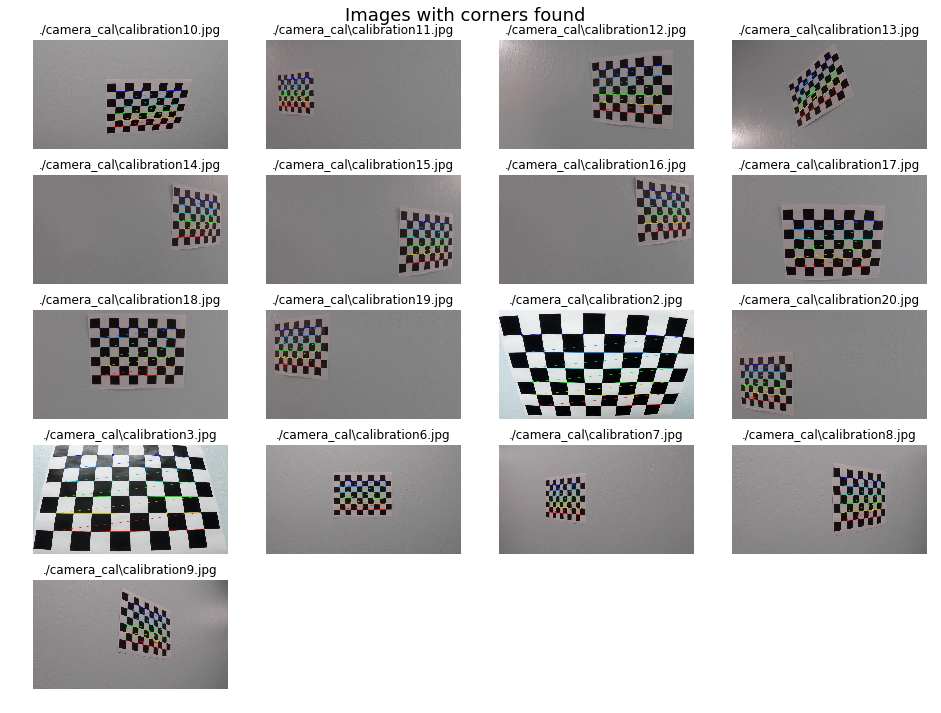

In [53]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

plt.figure(figsize=(16, 12)) 
plt.figtext(0.5,0.9,'Images with corners found', fontsize=18, ha='center')
# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    #print(i)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        plt.subplot(5, 4, len(imgpoints))
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
plt.show()
#cv2.destroyAllWindows()
#print(objpoints)
#print(imgpoints)

# Use the object points and image points generated in the above step to undistort the images

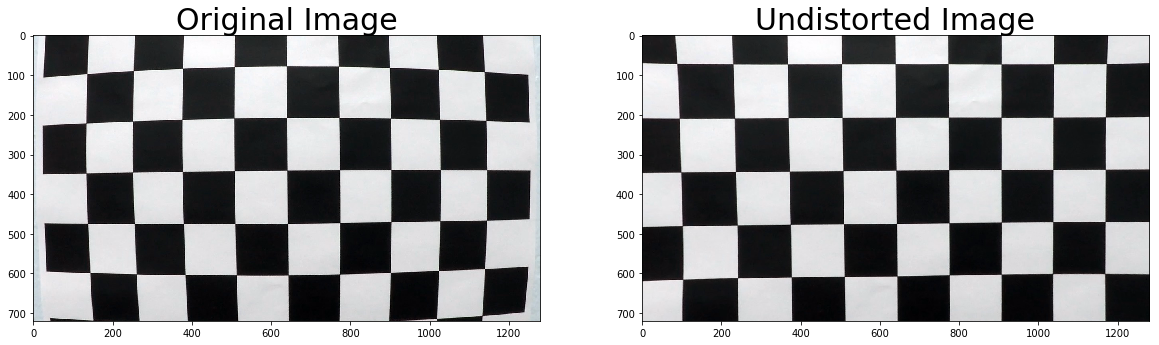

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/after_calibration/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/calibration_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
dist_pickle = pickle.load( open( "./camera_cal/calibration_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

img = cv2.imread('./camera_cal/calibration1.jpg')
nx = 9 # the number of inside corners in x
ny = 5 # the number of inside corners in y

In [5]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    #print('aaaa')
    print(ret)
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        #print('bbb')
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

True


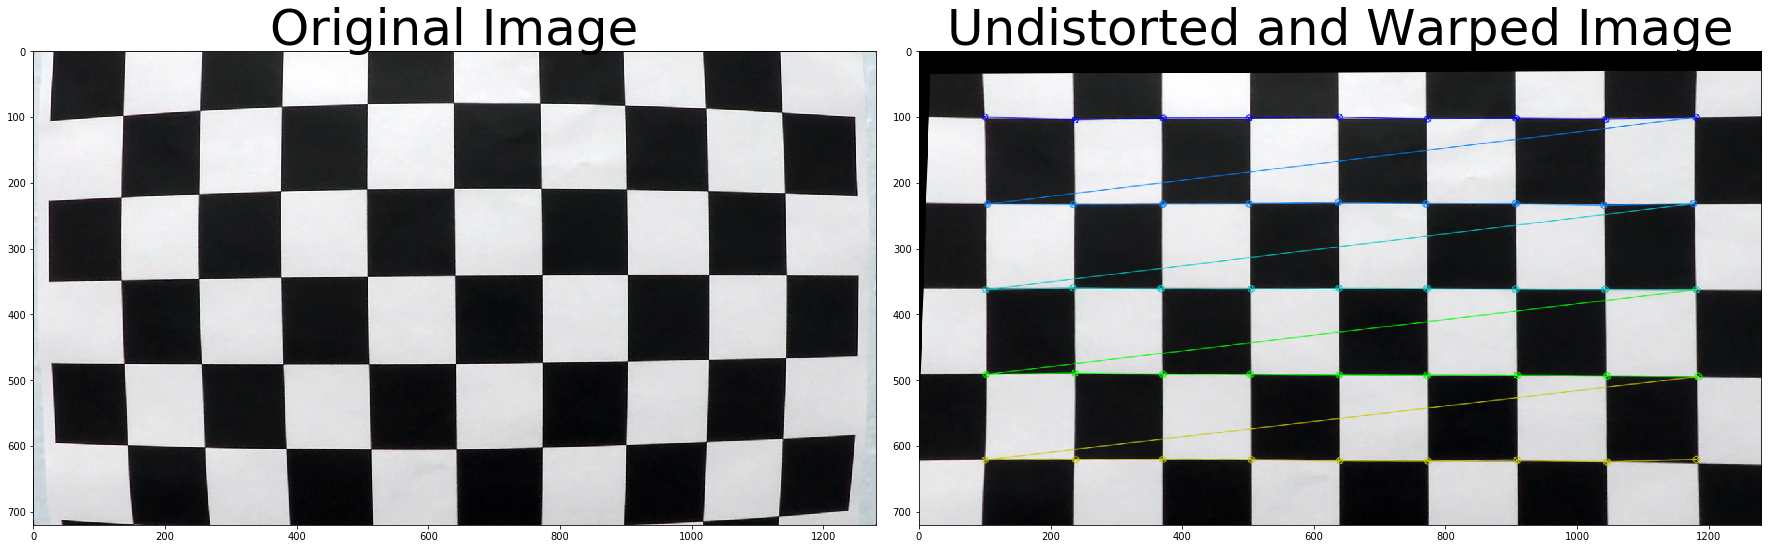

In [6]:
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Image undistortion on one of the test images

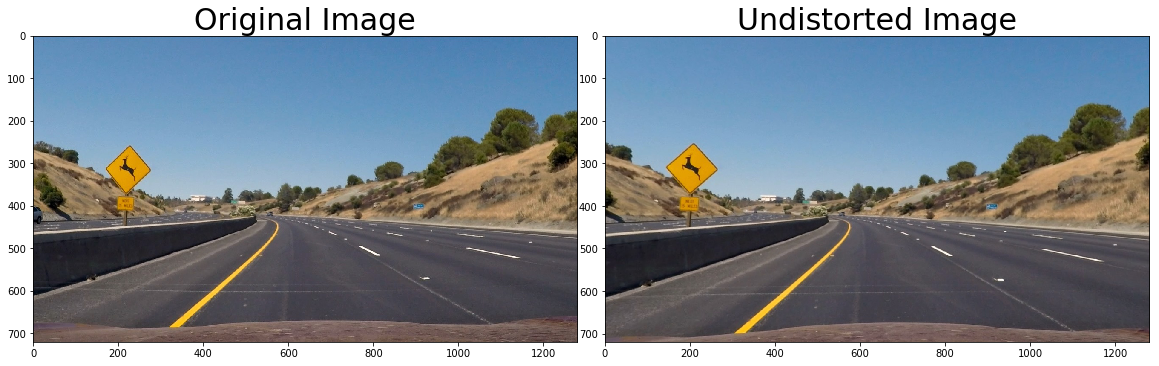

In [57]:
#test_img = mpimg.imread('./test_images/straight_lines2.jpg')
test_img = mpimg.imread('./test_images/test2.jpg')

test_img_undist = cv2.undistort(test_img, mtx, dist, None, mtx)
r,g,b = cv2.split(test_img_undist)       # get b,g,r
test_img_undist_bgr = cv2.merge([b,g,r])     # switch it to rgb. so that the imshow can display correctly
cv2.imwrite('./test_images/test2_undist.jpg',test_img_undist_bgr)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_img_undist)
ax2.set_title('Undistorted Image', fontsize=30)

# Test the undistortion and unwarping on the straight_lines2.jpg image

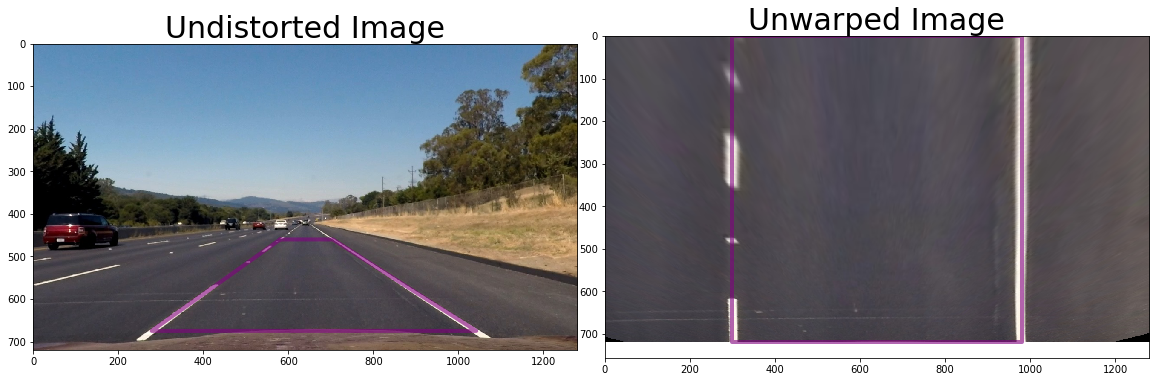

In [62]:
test_img = mpimg.imread('./test_images/straight_lines2.jpg')

test_img_undist = cv2.undistort(test_img, mtx, dist, None, mtx)
r,g,b = cv2.split(test_img_undist)       # get b,g,r
test_img_undist_bgr = cv2.merge([b,g,r])     # switch it to rgb. so that the imshow can display correctly
cv2.imwrite('./test_images/straight_lines2_undist.jpg',test_img_undist_bgr)

h = test_img.shape[0]
w = test_img.shape[1]

#src = np.float32([(602,445), (681,445), (316,650), (1000,650)])
src = np.float32([(581,460), (705,460), (279,675), (1042,675)])
dst = np.float32([(300,0), (w-300,0), (300,h), (w-300,h)])

def unwarp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)   
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, M_inv  

test_img_undist_warped, M, M_inv = unwarp(test_img_undist, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img_undist)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='purple', alpha=0.6, linewidth=4, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)

ax2.imshow(test_img_undist_warped)
x2 = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
y2 = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax2.plot(x2, y2, color='purple', alpha=0.6, linewidth=4, solid_capstyle='round', zorder=2)
ax2.set_title('Unwarped Image', fontsize=30)

# Define a function that applies Sobel x or y, then takes an absolute value and applies a threshold.

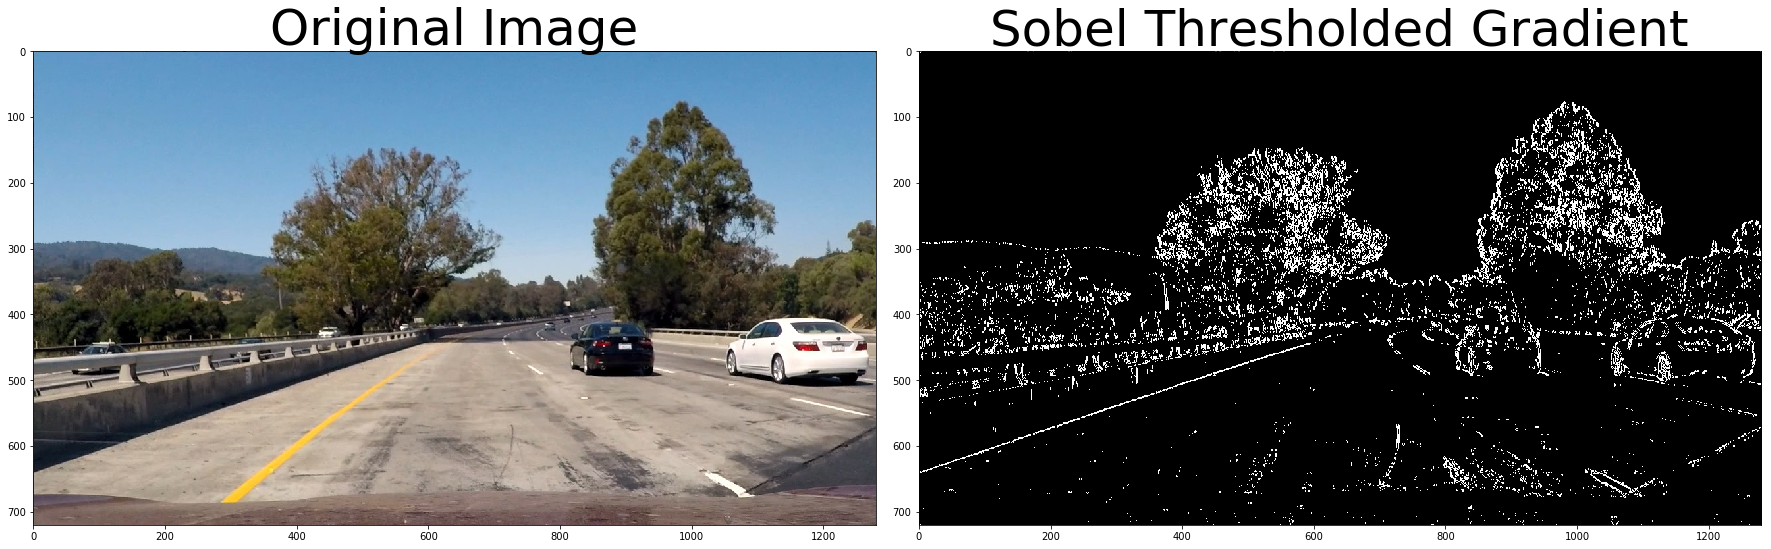

In [8]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100

image = cv2.imread('./test_images/test1.jpg')

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
#grad_binary = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(0, 40))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

b,g,r = cv2.split(image)       # get b,g,r
image = cv2.merge([r,g,b])     # switch it to rgb. so that the imshow can display correctly

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap ='gray' )
ax2.set_title('Sobel Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values

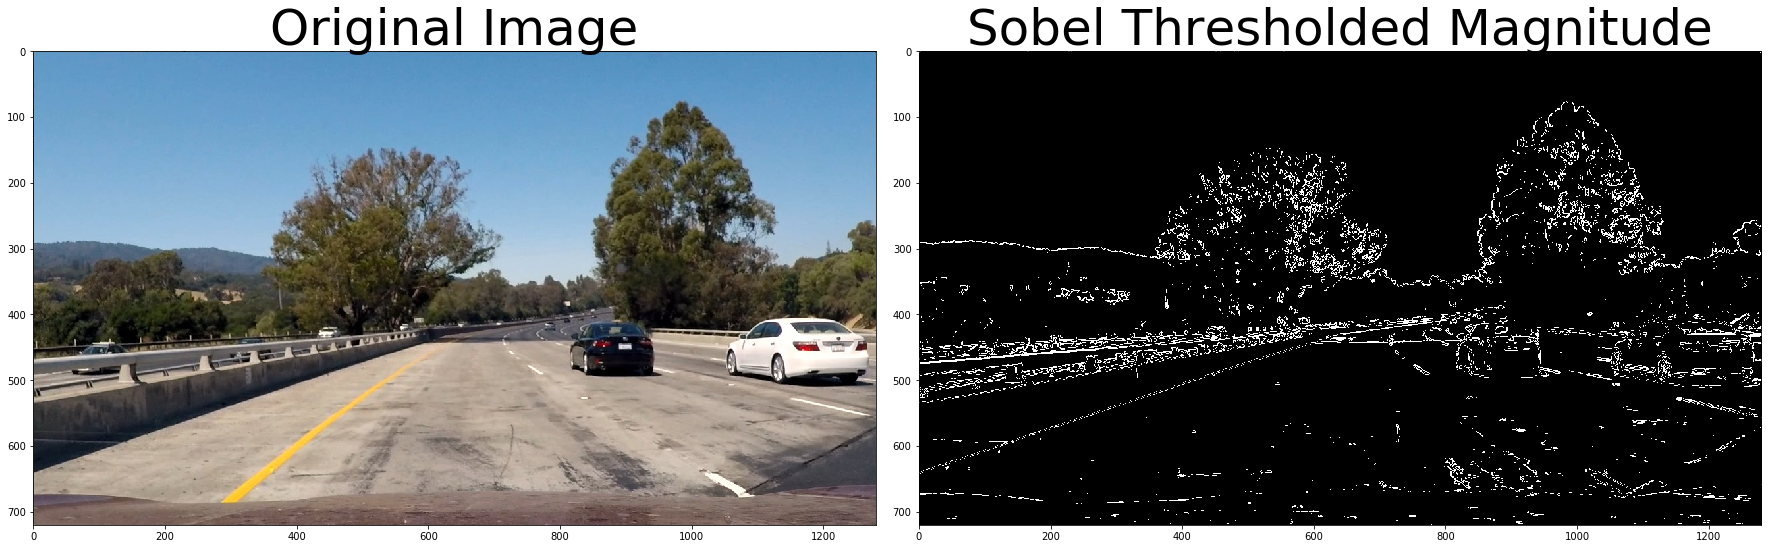

In [9]:
# Read in an image
image = mpimg.imread('./test_images/test1.jpg')

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(40, 80))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Sobel Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Define a function to threshold an image for a given range and Sobel kernel

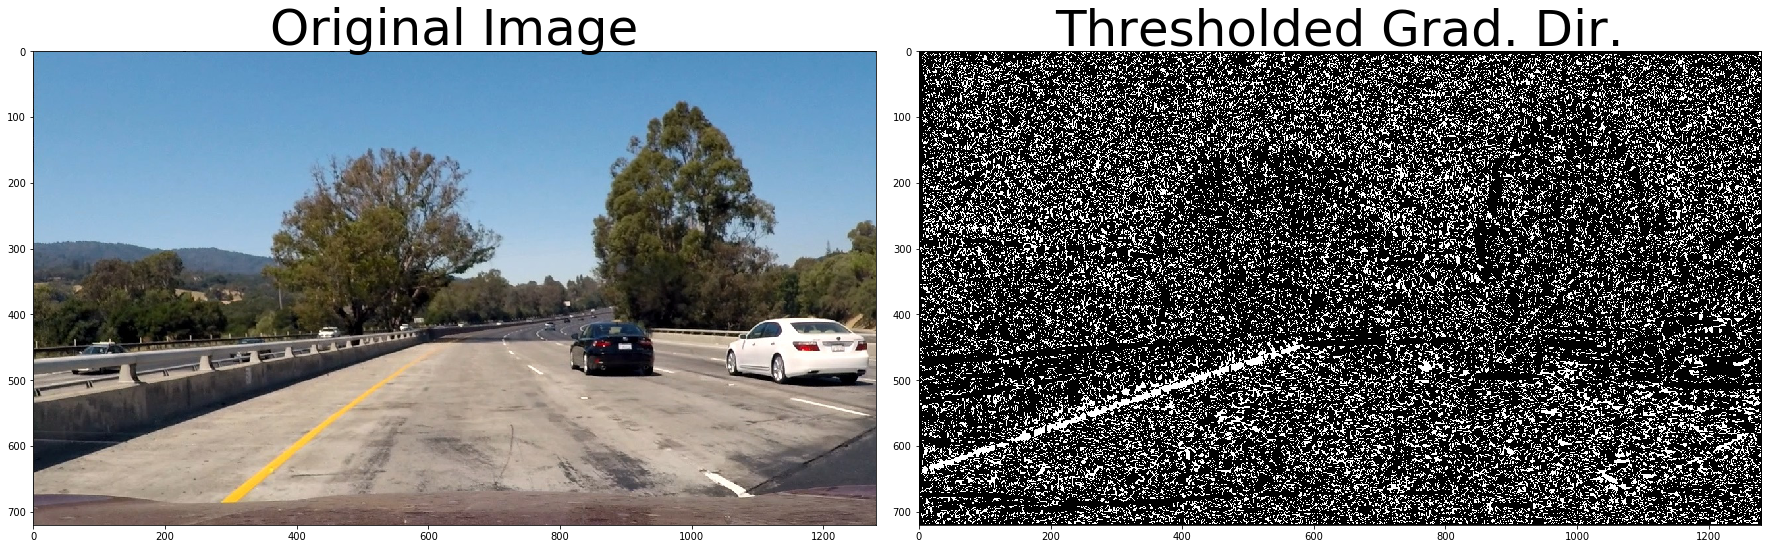

In [10]:
# Read in an image
image = mpimg.imread('./test_images/test1.jpg')

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(1.0, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Combining and applying each of the thresholding functions defined above

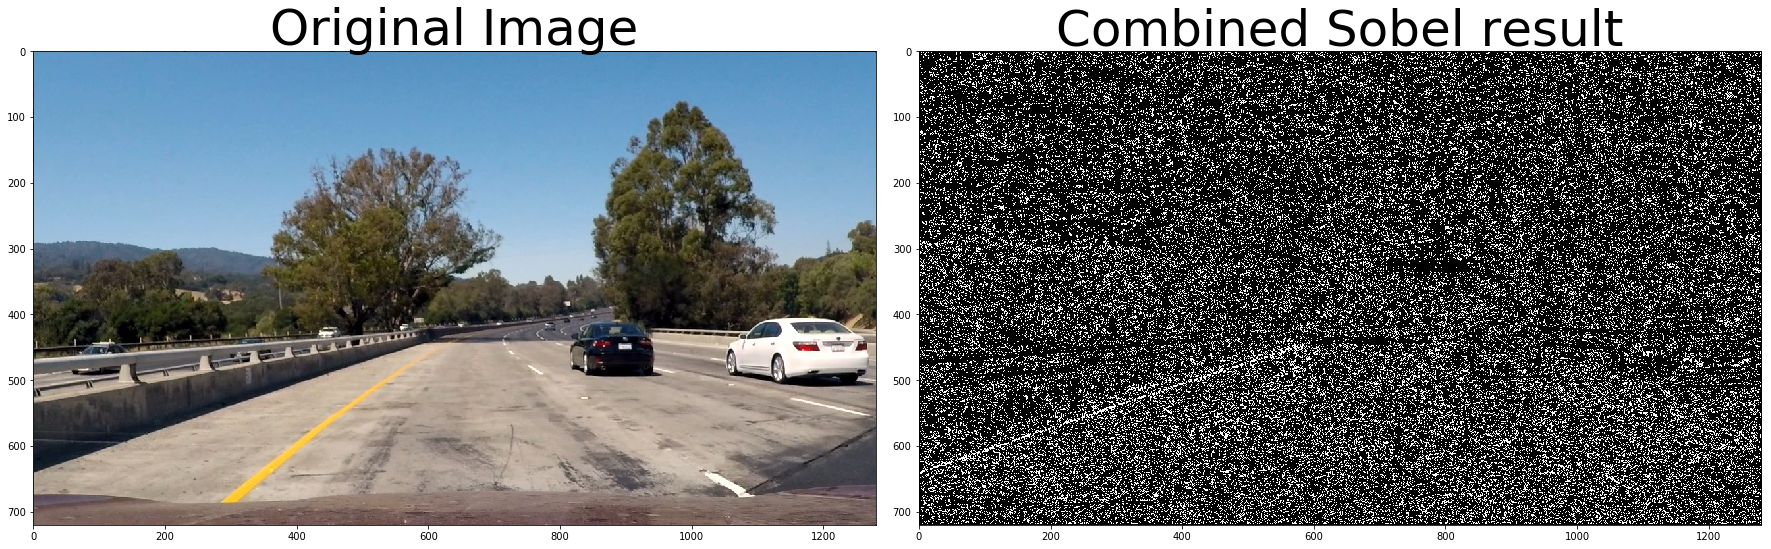

In [11]:
image = mpimg.imread('./test_images/test1.jpg')

ksize = 3

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 20))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 80))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(1.0, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Combined Sobel result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)

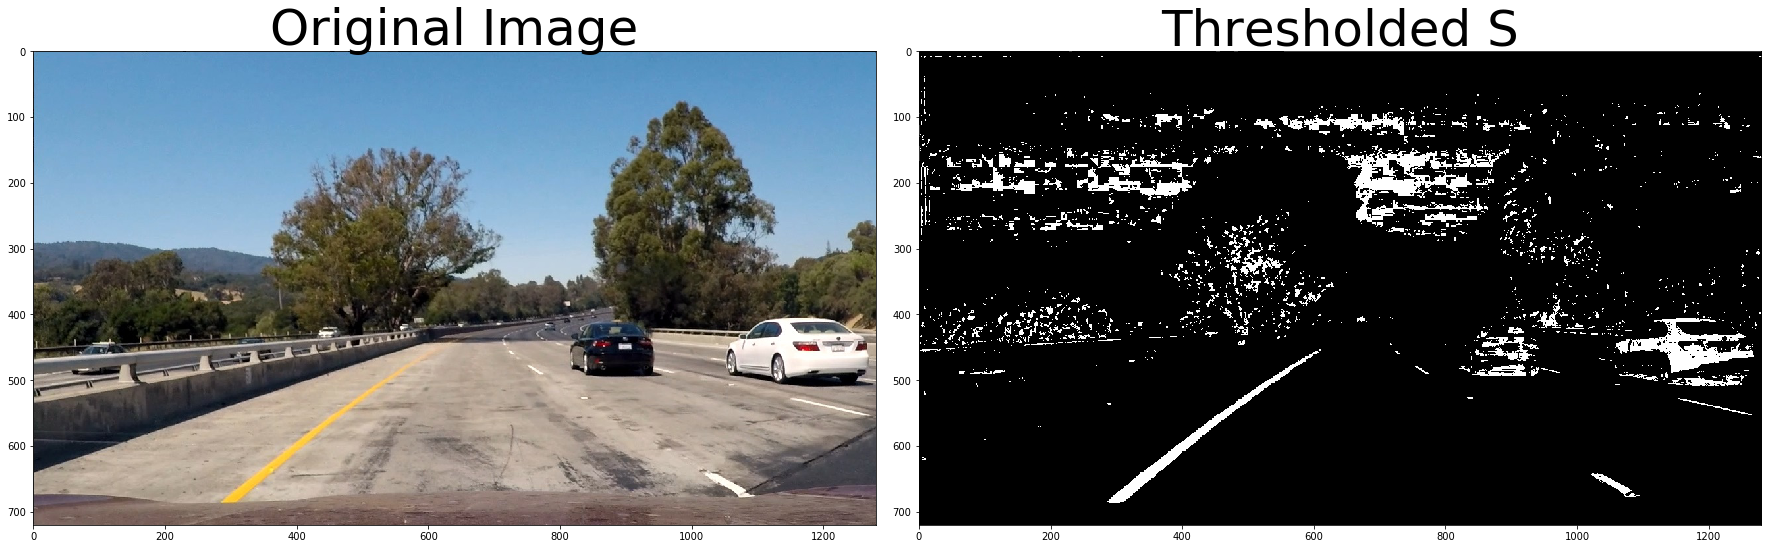

In [12]:
image = mpimg.imread('./test_images/test1.jpg') 

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result        
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(image, thresh=(130, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Define a function that thresholds the red-channel of RGB

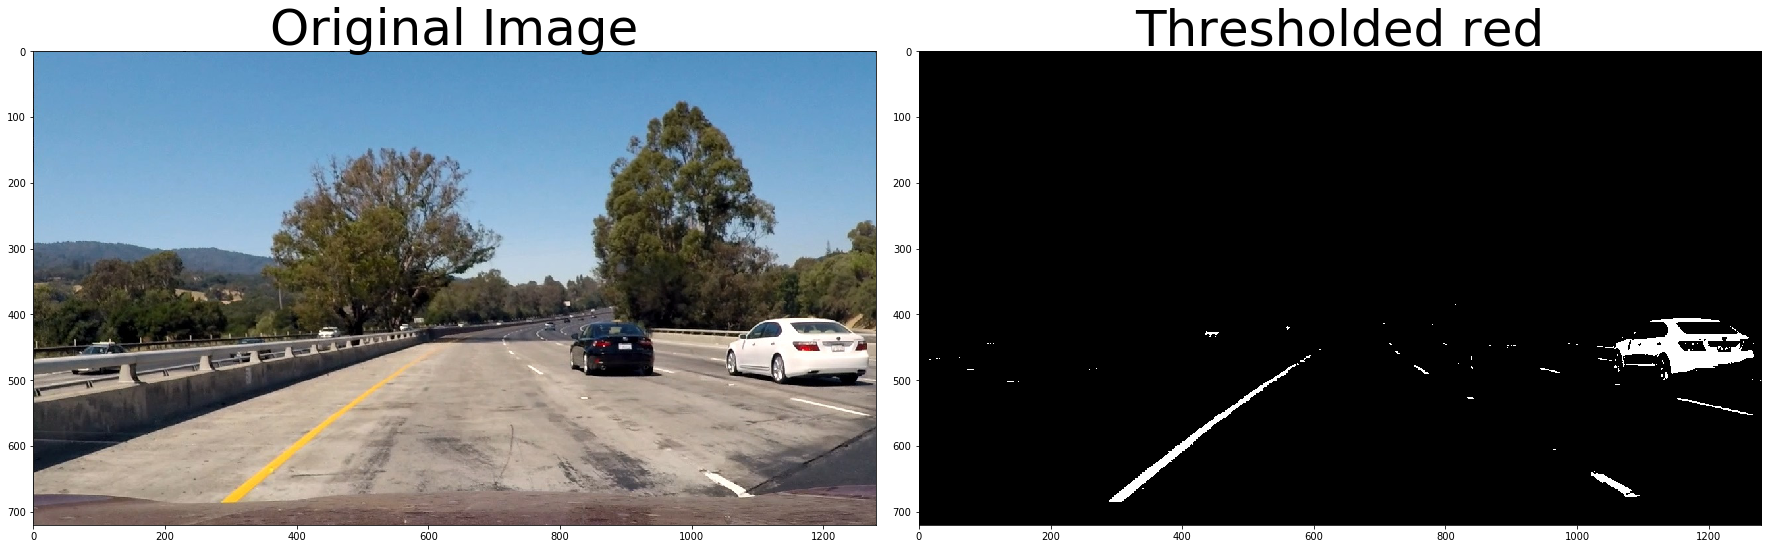

In [13]:
image = mpimg.imread('./test_images/test1.jpg') 

# Define a function that thresholds the red-channel of RGB
def red_select(img, thresh=(0, 255)):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

red_binary = red_select(image, thresh=(230, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(red_binary, cmap='gray')
ax2.set_title('Thresholded red', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Combine the HSL and Sobel gradient X filters

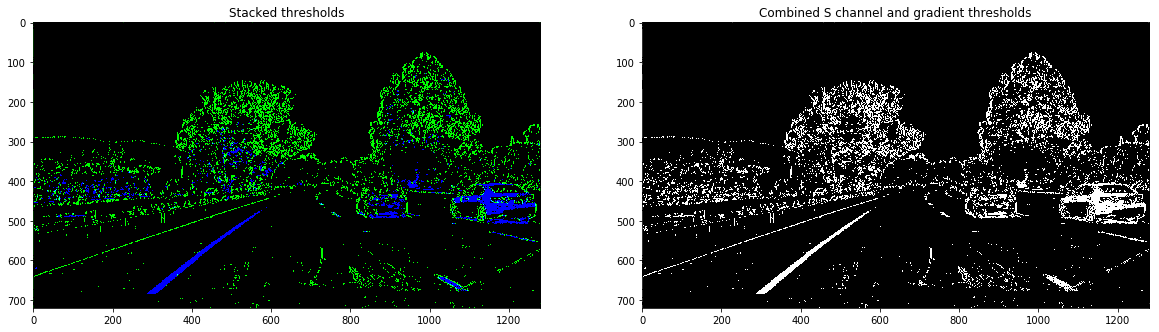

In [14]:
image = mpimg.imread('./test_images/test1.jpg')

ksize = 3

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
hls_binary = hls_select(image, thresh=(160, 255))

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(gradx), gradx, hls_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(gradx)
combined_binary[(hls_binary == 1) | (gradx == 1)] = 1


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

# Combine the Saturation and Red channel filters

(720, 1280)
1280


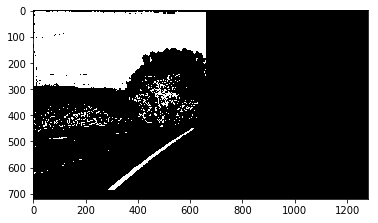

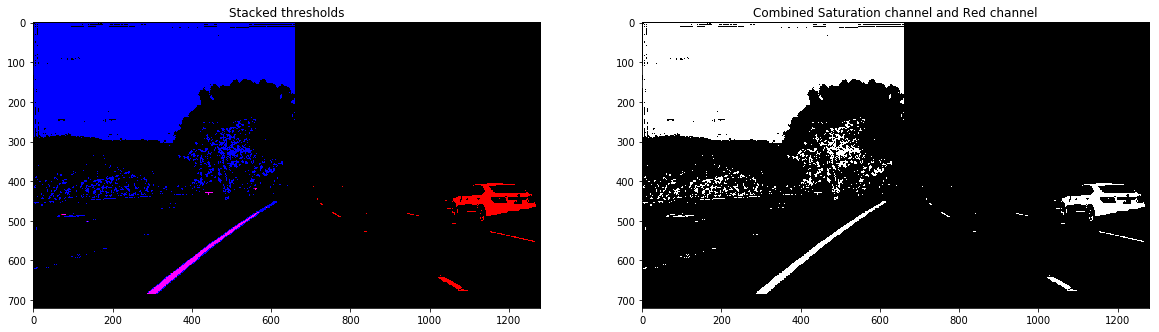

In [66]:
image = mpimg.imread('./test_images/test1.jpg')
#image = mpimg.imread('./test_images/test2.jpg')

ksize = 3

# Apply each of the thresholding functions
# Used to use (215, 255)  (110, 255). The combined binary result is bad
red_binary = red_select(image, thresh=(235, 255))
hls_binary = hls_select(image, thresh=(115, 255))

# Mask the right half as zero (black) 
# meaning only use the hls results for the left half of the image
# Therefore, the yellow lane is detected using the combination of both red_binary and hls_binary
# While the white lane is only detected using the red_binary
l_r_midpoint = 660
w = hls_binary.shape[1]
print(hls_binary.shape)
print(w)
hls_binary[:, l_r_midpoint:w] = 0

plt.imshow(hls_binary, cmap='gray')


# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack((red_binary, np.zeros_like(red_binary), hls_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(red_binary)
combined_binary[(hls_binary == 1) | (red_binary == 1)] = 1


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined Saturation channel and Red channel')
ax2.imshow(combined_binary, cmap='gray')

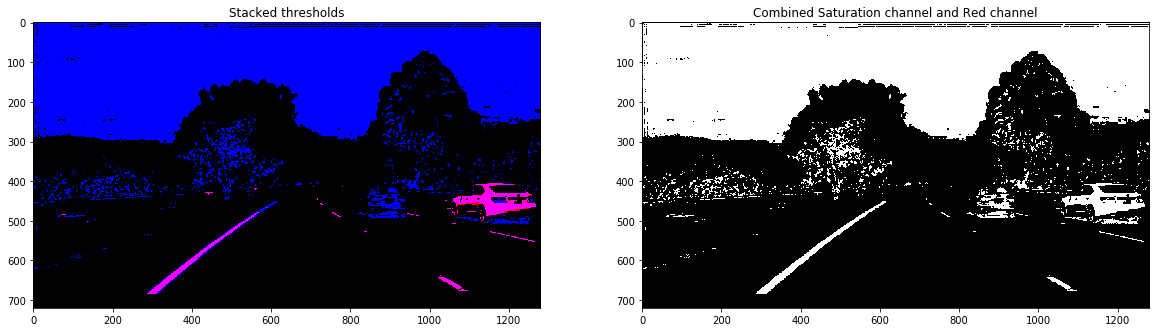

In [64]:
image = mpimg.imread('./test_images/test1.jpg')
#image = mpimg.imread('./test_images/test2.jpg')

ksize = 3

# Apply each of the thresholding functions
# Used to use (215, 255)  (110, 255). The combined binary result is bad
red_binary = red_select(image, thresh=(235, 255))
hls_binary = hls_select(image, thresh=(115, 255))


# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack((red_binary, np.zeros_like(red_binary), hls_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(red_binary)
combined_binary[(hls_binary == 1) | (red_binary == 1)] = 1


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined Saturation channel and Red channel')
ax2.imshow(combined_binary, cmap='gray')

# Do un-distortion and un-warping on the binary image

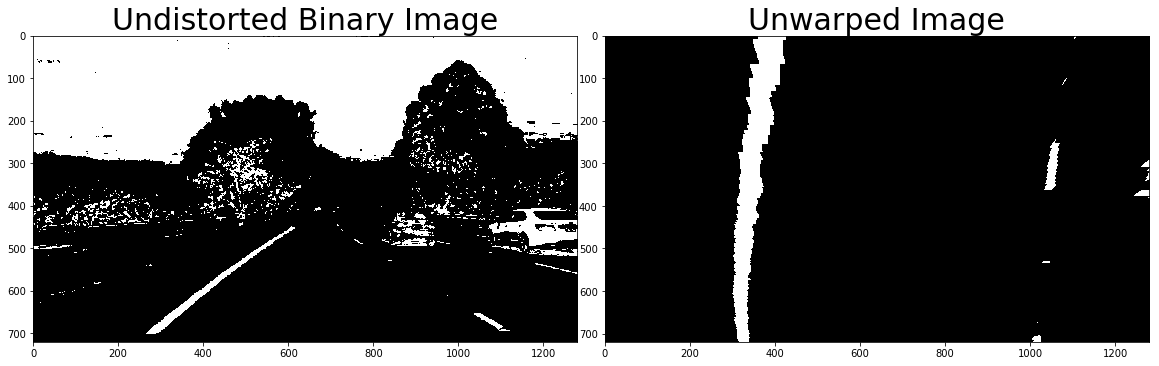

In [65]:
combined_binary_undist = cv2.undistort(combined_binary, mtx, dist, None, mtx)
combined_binary_undist_warped, M, M_inv = unwarp(combined_binary_undist, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(combined_binary_undist, cmap='gray')
ax1.set_title('Undistorted Binary Image', fontsize=30)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax2.imshow(combined_binary_undist_warped, cmap='gray')
ax2.set_title('Unwarped Image', fontsize=30)

# Define the polyfit based on the non-zero pixel counting and histogram generation

In [17]:
def histogram_polyfit(image):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)    
    #right_fit = np.polyfit(righty, rightx, 2)
        
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:    
        right_fit = np.polyfit(righty, rightx, 2)
    
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles

# Plot the sliding windows and fitted curves

(720, 0)

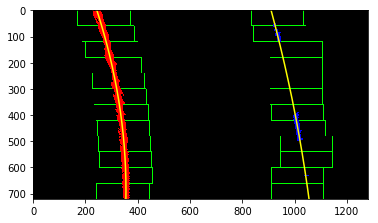

In [18]:
# Generate x and y values for plotting
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = histogram_polyfit(combined_binary_undist_warped)

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((combined_binary_undist_warped, combined_binary_undist_warped, combined_binary_undist_warped))*255)

ploty = np.linspace(0, combined_binary_undist_warped.shape[0]-1, combined_binary_undist_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    
# Identify the x and y positions of all nonzero pixels in the image
nonzero = combined_binary_undist_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Perform the polyfit based on the calculation of the histogram

In [19]:
def last_frame_polyfit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

# Define the function for calcuating the curvature

In [20]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
def curvature(binary_img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 
    left_curverad, right_curverad = (0, 0)
    
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    
    y_eval = np.max(ploty)
    #left_fit_cr = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fit_cr = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # curvation in meters
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [21]:
lef_curv, right_curv = curvature(combined_binary_undist_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature:', lef_curv, 'm,', right_curv, 'm')

Radius of curvature: 697.772189503 m, 1756.30813074 m


# Define the function for calcuating the distance to lane center

In [22]:
def center_dist(binary_img, left_fit, right_fit):
    center_dist = 0
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    if right_fit is not None and left_fit is not None:
        car_position = binary_img.shape[1]/2
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_dist

In [23]:
center_distance = center_dist(combined_binary_undist_warped, left_fit, right_fit)
print('Distance from lane center:', center_distance, 'm')

Distance from lane center: -0.342860918282 m


# Define the function for plotting the results/data back to the original image

In [24]:
def draw_results(orig_img, binary_img, left_fit, right_fit, M_inv, curve, center_distance):
    
    if left_fit is None or right_fit is None:
        return orig_img
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (M_inv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
    
    img_copy = np.copy(orig_img)
    # Combine the result with the original image
    img_with_lane = cv2.addWeighted(img_copy, 1, newwarp, 0.4, 0)
    
    # Add the result text in the image
    new_img = np.copy(img_with_lane)
    h = img_with_lane.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'curve radius: ' + '{:04.2f}'.format(curve) + 'm'
    cv2.putText(img_with_lane, text, (10,50), font, 1.5, (255,255,200), 2)

    abs_center_dist = abs(center_distance)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + 'from center'
    cv2.putText(img_with_lane, text, (10,100), font, 1.5, (255,255,200), 2)
    
    return img_with_lane


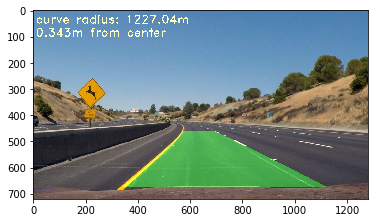

In [25]:
curve = (lef_curv+right_curv)/2
image_with_lanes = draw_results(image, combined_binary_undist_warped, left_fit, right_fit, M_inv, curve, center_distance)
plt.imshow(image_with_lanes)

# Define a class for holding the lane detection related values

In [34]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
    def update_fit(self, fit, inds):        
        # Maintain a group of last 4 fits; Add the fit to the fit group is it exists
        if fit is not None:
            #print('add fit aaa')
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 4:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-4:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # if no fit is found, remove one fit from the group (the oldest one)
        else:
            #print('add fit bbb')
            self.detected = False
            if len(self.current_fit) > 0:
                # remove oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                #  best_fit is average of the group of fits
                self.best_fit = np.average(self.current_fit, axis=0)
    

# Define the function for the overall image processing pipeline

In [35]:
def pipeline(img):
    
    ksize = 3

    '''
    # Apply each of the thresholding functions
    # Used to use (215, 255)  (110, 255). The combined binary result is bad
    #red_binary = red_select(img, thresh=(230, 255))
    #hls_binary = hls_select(img, thresh=(130, 255))
    red_binary = red_select(img, thresh=(215, 255))
    hls_binary = hls_select(img, thresh=(115, 255))
    '''
    
    # Apply each of the thresholding functions
    # Used to use (215, 255)  (110, 255). The combined binary result is bad
    red_binary = red_select(img, thresh=(235, 255))
    hls_binary = hls_select(img, thresh=(115, 255))

    # Mask the right half as zero (black) 
    # meaning only use the hls results for the left half of the image
    # Therefore, the yellow lane is detected using the combination of both red_binary and hls_binary
    # While the white lane is only detected using the red_binary
    l_r_midpoint = 660
    w = hls_binary.shape[1]
    hls_binary[:, l_r_midpoint:w] = 0
    

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(red_binary)
    combined_binary[(hls_binary == 1) | (red_binary == 1)] = 1
    
    
    '''
    h = img.shape[0]
    w = img.shape[1]
    src = np.float32([(602,445), (681,445), (279,675), (1042,675)])
    dst = np.float32([(300,0), (w-300,0), (300,h), (w-300,h)])
    # Undistort
    img_undistort = cv2.undistort(img, mtx, dist, None, mtx)
    #print(img_undistort.shape)
    
    # Perspective Transform
    img_undist_warped, M, M_inv = unwarp(img_undistort, src, dst)
    '''
    # Note that the mtx dist src dst are calculated in the cells at the beginning 
    combined_binary_undist = cv2.undistort(combined_binary, mtx, dist, None, mtx)
    combined_binary_undist_warped, M, M_inv = unwarp(combined_binary_undist, src, dst)
    

    return combined_binary_undist_warped, M_inv

#img_bin, M_inv = pipeline(image)
#plt.imshow(img_bin, cmap ='gray')

# Define the function for transforming each frame of the video

In [37]:
def transform_img(img):
    img_copy = np.copy(img)
    img_bin = np.zeros_like(img_copy)
    img_bin, M_inv = pipeline(img_copy)
    
    # Use histogram_polyfit to re-calculate the fit, if either left or right lines were not detected in last frame   
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = histogram_polyfit(img_bin)
    # Calculate the fit from scratch using last_frame_polyfit, if both left and right lines were detected
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = last_frame_polyfit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # If the fit jumps too much, do not add that fit
    # jumps too much = difference in x-intercepts > 100 px
    if l_fit is not None and r_fit is not None:
        #print('ccc')
        # calculate x-intercept for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        #print(x_int_diff)
        if abs(728 - x_int_diff) > 100:
            #print('ddd')
            l_fit = None
            r_fit = None
            
    l_line.update_fit(l_fit, l_lane_inds)
    r_line.update_fit(r_fit, r_lane_inds)
    
    # Draw the results/data back to the image
    #print(l_line.best_fit)
    #print(r_line.best_fit)
    if l_line.best_fit is not None and r_line.best_fit is not None:
        #print('aaa')
        rad_l, rad_r = curvature(img_bin, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)
        d_center = center_dist(img_bin, l_line.best_fit, r_line.best_fit)
        
        img_out = draw_results(img_copy, img_bin, l_line.best_fit, r_line.best_fit, M_inv, (rad_l+rad_r)/2, d_center)
    else:
        #print('bbb')
        img_out = img_copy
    
    return img_out

In [38]:
l_line = Line()
r_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(24,27)
processed_video = video_input1.fl_image(transform_img)
%time processed_video.write_videofile(video_output1, audio=False)

694.555503687
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

694.555503687


  0%|          | 1/1261 [00:00<02:07,  9.84it/s]

692.580034699


  0%|          | 2/1261 [00:00<02:11,  9.59it/s]

690.373823179


  0%|          | 3/1261 [00:00<02:13,  9.41it/s]

690.667172748


  0%|          | 4/1261 [00:00<02:16,  9.22it/s]

689.373322261


  0%|          | 5/1261 [00:00<02:16,  9.19it/s]

686.569962268


  0%|          | 6/1261 [00:00<02:19,  9.01it/s]

685.98090657


  1%|          | 7/1261 [00:00<02:18,  9.06it/s]

691.500731867


  1%|          | 8/1261 [00:00<02:18,  9.02it/s]

694.770564825


  1%|          | 9/1261 [00:00<02:17,  9.14it/s]

692.514188897


  1%|          | 10/1261 [00:01<02:16,  9.20it/s]

690.182230012
691.652562706


  1%|          | 12/1261 [00:01<02:11,  9.50it/s]

689.549953411


  1%|          | 13/1261 [00:01<02:13,  9.35it/s]

689.311856773


  1%|          | 14/1261 [00:01<02:15,  9.20it/s]

680.040050446


  1%|          | 15/1261 [00:01<02:14,  9.24it/s]

676.501930304


  1%|▏         | 16/1261 [00:01<02:15,  9.20it/s]

676.666916547


  1%|▏         | 17/1261 [00:01<02:13,  9.30it/s]

675.016642955


  1%|▏         | 18/1261 [00:01<02:12,  9.37it/s]

675.182666276


  2%|▏         | 19/1261 [00:02<02:12,  9.38it/s]

677.105040022


  2%|▏         | 20/1261 [00:02<02:12,  9.38it/s]

676.944942866


  2%|▏         | 21/1261 [00:02<02:11,  9.40it/s]

682.752294902


  2%|▏         | 22/1261 [00:02<02:14,  9.22it/s]

687.212567956


  2%|▏         | 23/1261 [00:02<02:12,  9.34it/s]

686.06383086


  2%|▏         | 24/1261 [00:02<02:12,  9.37it/s]

679.085537028


  2%|▏         | 25/1261 [00:02<02:09,  9.55it/s]

688.171026979


  2%|▏         | 26/1261 [00:02<02:08,  9.58it/s]

691.667292126


  2%|▏         | 27/1261 [00:02<02:12,  9.31it/s]

697.276096249


  2%|▏         | 28/1261 [00:03<02:14,  9.19it/s]

698.579499462


  2%|▏         | 29/1261 [00:03<02:12,  9.31it/s]

699.049128468


  2%|▏         | 30/1261 [00:03<02:10,  9.40it/s]

698.090624158


  2%|▏         | 31/1261 [00:03<02:10,  9.41it/s]

695.529487895


  3%|▎         | 32/1261 [00:03<02:09,  9.50it/s]

696.231577747


  3%|▎         | 33/1261 [00:03<02:08,  9.58it/s]

702.781982461
708.328263702


  3%|▎         | 35/1261 [00:03<02:04,  9.83it/s]

698.557676282
694.420530017


  3%|▎         | 37/1261 [00:03<02:02,  9.99it/s]

689.127179735
687.361112446


  3%|▎         | 39/1261 [00:04<02:01, 10.09it/s]

687.459794392
684.561030469


  3%|▎         | 41/1261 [00:04<02:01, 10.02it/s]

685.822056979
684.748964348


  3%|▎         | 43/1261 [00:04<02:02,  9.96it/s]

684.978502564


  3%|▎         | 44/1261 [00:04<02:05,  9.68it/s]

686.211504762


  4%|▎         | 45/1261 [00:04<02:04,  9.77it/s]

689.08208998
689.282125984


  4%|▎         | 47/1261 [00:04<02:03,  9.85it/s]

692.285818467


  4%|▍         | 48/1261 [00:05<02:06,  9.61it/s]

688.772197513


  4%|▍         | 49/1261 [00:05<02:07,  9.54it/s]

681.536250134


  4%|▍         | 50/1261 [00:05<02:05,  9.62it/s]

681.638350627


  4%|▍         | 51/1261 [00:05<02:07,  9.49it/s]

678.958067835


  4%|▍         | 52/1261 [00:05<02:05,  9.64it/s]

677.588134568


  4%|▍         | 53/1261 [00:05<02:06,  9.52it/s]

676.147882578


  4%|▍         | 54/1261 [00:05<02:06,  9.55it/s]

677.251275739


  4%|▍         | 55/1261 [00:05<02:07,  9.47it/s]

679.062413296
679.311996639


  5%|▍         | 57/1261 [00:05<02:05,  9.62it/s]

681.957211758


  5%|▍         | 58/1261 [00:06<02:04,  9.69it/s]

682.665801361


  5%|▍         | 59/1261 [00:06<02:05,  9.61it/s]

683.676735241


  5%|▍         | 60/1261 [00:06<02:05,  9.61it/s]

685.175425405


  5%|▍         | 61/1261 [00:06<02:07,  9.38it/s]

682.564930078


  5%|▍         | 62/1261 [00:06<02:06,  9.47it/s]

680.29216092


  5%|▍         | 63/1261 [00:06<02:06,  9.49it/s]

680.989726733


  5%|▌         | 64/1261 [00:06<02:04,  9.63it/s]

682.98105615


  5%|▌         | 65/1261 [00:06<02:06,  9.44it/s]

681.387668951


  5%|▌         | 66/1261 [00:06<02:08,  9.33it/s]

682.259660575


  5%|▌         | 67/1261 [00:07<02:06,  9.45it/s]

684.08458572


  5%|▌         | 68/1261 [00:07<02:07,  9.38it/s]

682.14291128


  5%|▌         | 69/1261 [00:07<02:06,  9.41it/s]

685.107692252


  6%|▌         | 70/1261 [00:07<02:08,  9.29it/s]

689.457243708


  6%|▌         | 71/1261 [00:07<02:08,  9.29it/s]

687.647386687


  6%|▌         | 72/1261 [00:07<02:09,  9.20it/s]

687.991862276


  6%|▌         | 73/1261 [00:07<02:10,  9.10it/s]

680.592705402


  6%|▌         | 74/1261 [00:07<02:11,  9.05it/s]

670.840420716


  6%|▌         | 75/1261 [00:07<02:12,  8.94it/s]

669.028027667


  6%|▌         | 76/1261 [00:08<02:12,  8.91it/s]

676.2340944


  6%|▌         | 77/1261 [00:08<02:14,  8.78it/s]

677.267984972


  6%|▌         | 78/1261 [00:08<02:14,  8.77it/s]

679.410556379


  6%|▋         | 79/1261 [00:08<02:13,  8.84it/s]

681.878560797


  6%|▋         | 80/1261 [00:08<02:10,  9.04it/s]

681.154154339


  6%|▋         | 81/1261 [00:08<02:11,  8.97it/s]

683.737746513


  7%|▋         | 82/1261 [00:08<02:14,  8.79it/s]

687.863668168


  7%|▋         | 83/1261 [00:08<02:14,  8.78it/s]

695.435984286


  7%|▋         | 84/1261 [00:08<02:11,  8.92it/s]

703.879505822


  7%|▋         | 85/1261 [00:09<02:11,  8.96it/s]

705.734621202


  7%|▋         | 86/1261 [00:09<02:10,  9.00it/s]

703.201098342


  7%|▋         | 87/1261 [00:09<02:07,  9.22it/s]

693.63895641


  7%|▋         | 88/1261 [00:09<02:08,  9.13it/s]

695.95283897


  7%|▋         | 89/1261 [00:09<02:07,  9.17it/s]

689.663869763


  7%|▋         | 90/1261 [00:09<02:07,  9.19it/s]

691.190096404


  7%|▋         | 91/1261 [00:09<02:07,  9.19it/s]

689.168520671


  7%|▋         | 92/1261 [00:09<02:06,  9.21it/s]

687.699476873


  7%|▋         | 93/1261 [00:09<02:06,  9.22it/s]

684.953064916


  7%|▋         | 94/1261 [00:10<02:05,  9.31it/s]

684.878502441


  8%|▊         | 95/1261 [00:10<02:04,  9.38it/s]

682.76066584


  8%|▊         | 96/1261 [00:10<02:04,  9.38it/s]

682.119539853


  8%|▊         | 97/1261 [00:10<02:06,  9.23it/s]

686.042575843


  8%|▊         | 98/1261 [00:10<02:07,  9.13it/s]

682.327949481


  8%|▊         | 99/1261 [00:10<02:07,  9.11it/s]

679.457727642


  8%|▊         | 100/1261 [00:10<02:06,  9.16it/s]

668.799653702


  8%|▊         | 101/1261 [00:10<02:07,  9.12it/s]

668.023591126


  8%|▊         | 102/1261 [00:10<02:06,  9.16it/s]

671.687605592


  8%|▊         | 103/1261 [00:10<02:06,  9.17it/s]

671.512078322


  8%|▊         | 104/1261 [00:11<02:05,  9.22it/s]

676.836542228


  8%|▊         | 105/1261 [00:11<02:06,  9.15it/s]

679.629876564


  8%|▊         | 106/1261 [00:11<02:07,  9.06it/s]

684.4012648


  8%|▊         | 107/1261 [00:11<02:07,  9.04it/s]

685.321367212


  9%|▊         | 108/1261 [00:11<02:04,  9.24it/s]

690.871435712


  9%|▊         | 109/1261 [00:11<02:05,  9.16it/s]

693.170220137


  9%|▊         | 110/1261 [00:11<02:05,  9.17it/s]

692.448140248


  9%|▉         | 111/1261 [00:11<02:05,  9.16it/s]

691.974828415


  9%|▉         | 112/1261 [00:11<02:04,  9.26it/s]

691.381109659


  9%|▉         | 113/1261 [00:12<02:02,  9.34it/s]

687.233380248


  9%|▉         | 114/1261 [00:12<02:03,  9.29it/s]

686.879291147


  9%|▉         | 115/1261 [00:12<02:05,  9.13it/s]

682.685550859


  9%|▉         | 116/1261 [00:12<02:10,  8.75it/s]

682.307671129


  9%|▉         | 117/1261 [00:12<02:14,  8.51it/s]

682.221374111


  9%|▉         | 118/1261 [00:12<02:16,  8.37it/s]

680.648646852


  9%|▉         | 119/1261 [00:12<02:19,  8.20it/s]

678.499259634


 10%|▉         | 120/1261 [00:12<02:18,  8.26it/s]

679.382981235


 10%|▉         | 121/1261 [00:13<02:18,  8.21it/s]

678.387046576


 10%|▉         | 122/1261 [00:13<02:21,  8.02it/s]

683.716360467


 10%|▉         | 123/1261 [00:13<02:24,  7.88it/s]

679.877956598


 10%|▉         | 124/1261 [00:13<02:26,  7.78it/s]

676.845970936


 10%|▉         | 125/1261 [00:13<02:23,  7.94it/s]

672.304602175


 10%|▉         | 126/1261 [00:13<02:23,  7.92it/s]

674.284754976


 10%|█         | 127/1261 [00:13<02:22,  7.96it/s]

674.563318778


 10%|█         | 128/1261 [00:13<02:19,  8.11it/s]

672.025444579


 10%|█         | 129/1261 [00:14<02:20,  8.03it/s]

672.316552742


 10%|█         | 130/1261 [00:14<02:19,  8.08it/s]

671.755389544


 10%|█         | 131/1261 [00:14<02:22,  7.94it/s]

670.619598239


 10%|█         | 132/1261 [00:14<02:18,  8.13it/s]

671.328773943


 11%|█         | 133/1261 [00:14<02:19,  8.07it/s]

674.81178014


 11%|█         | 134/1261 [00:14<02:19,  8.11it/s]

676.443358012


 11%|█         | 135/1261 [00:14<02:19,  8.09it/s]

679.402438488


 11%|█         | 136/1261 [00:14<02:19,  8.09it/s]

677.722039326


 11%|█         | 137/1261 [00:15<02:18,  8.10it/s]

680.230704698


 11%|█         | 138/1261 [00:15<02:18,  8.13it/s]

677.889935479


 11%|█         | 139/1261 [00:15<02:15,  8.29it/s]

683.217168999


 11%|█         | 140/1261 [00:15<02:11,  8.51it/s]

686.400415077


 11%|█         | 141/1261 [00:15<02:07,  8.77it/s]

687.857482124


 11%|█▏        | 142/1261 [00:15<02:04,  8.98it/s]

684.965145408


 11%|█▏        | 143/1261 [00:15<02:03,  9.07it/s]

684.041369687


 11%|█▏        | 144/1261 [00:15<02:02,  9.12it/s]

684.885384241


 11%|█▏        | 145/1261 [00:15<01:59,  9.37it/s]

690.099964599


 12%|█▏        | 146/1261 [00:16<01:59,  9.36it/s]

694.561697602


 12%|█▏        | 147/1261 [00:16<01:58,  9.38it/s]

692.277033255


 12%|█▏        | 148/1261 [00:16<01:59,  9.34it/s]

687.728124806


 12%|█▏        | 149/1261 [00:16<01:59,  9.30it/s]

684.560317413


 12%|█▏        | 150/1261 [00:16<01:58,  9.35it/s]

679.710042828


 12%|█▏        | 151/1261 [00:16<01:59,  9.28it/s]

682.877166485


 12%|█▏        | 152/1261 [00:16<02:01,  9.14it/s]

678.352713616


 12%|█▏        | 153/1261 [00:16<02:02,  9.07it/s]

681.749422839


 12%|█▏        | 154/1261 [00:16<02:03,  8.98it/s]

684.04802624


 12%|█▏        | 155/1261 [00:17<02:04,  8.89it/s]

684.411515115


 12%|█▏        | 156/1261 [00:17<02:02,  9.02it/s]

684.024826652


 12%|█▏        | 157/1261 [00:17<02:01,  9.08it/s]

681.484051713


 13%|█▎        | 158/1261 [00:17<02:03,  8.92it/s]

690.462395194


 13%|█▎        | 159/1261 [00:17<02:04,  8.83it/s]

691.370973128


 13%|█▎        | 160/1261 [00:17<02:03,  8.93it/s]

697.24248757


 13%|█▎        | 161/1261 [00:17<02:01,  9.06it/s]

695.822738502


 13%|█▎        | 162/1261 [00:17<02:00,  9.13it/s]

696.2406636


 13%|█▎        | 163/1261 [00:17<02:00,  9.09it/s]

696.629847081


 13%|█▎        | 164/1261 [00:18<02:00,  9.14it/s]

693.530086568


 13%|█▎        | 165/1261 [00:18<01:58,  9.26it/s]

691.555972369


 13%|█▎        | 166/1261 [00:18<01:58,  9.25it/s]

690.029220045


 13%|█▎        | 167/1261 [00:18<02:03,  8.87it/s]

691.251901072


 13%|█▎        | 168/1261 [00:18<02:03,  8.85it/s]

690.864148109


 13%|█▎        | 169/1261 [00:18<02:02,  8.89it/s]

693.020662568


 13%|█▎        | 170/1261 [00:18<02:00,  9.02it/s]

681.731853166


 14%|█▎        | 171/1261 [00:18<01:59,  9.12it/s]

687.37507478


 14%|█▎        | 172/1261 [00:18<01:57,  9.23it/s]

687.175504378


 14%|█▎        | 173/1261 [00:18<01:56,  9.30it/s]

688.198584505


 14%|█▍        | 174/1261 [00:19<01:57,  9.27it/s]

683.437597936


 14%|█▍        | 175/1261 [00:19<01:57,  9.22it/s]

675.528408588


 14%|█▍        | 176/1261 [00:19<01:59,  9.10it/s]

680.873057956


 14%|█▍        | 177/1261 [00:19<01:59,  9.11it/s]

685.428705922


 14%|█▍        | 178/1261 [00:19<02:00,  8.97it/s]

688.976922554


 14%|█▍        | 179/1261 [00:19<01:59,  9.08it/s]

694.802998344


 14%|█▍        | 180/1261 [00:19<02:05,  8.59it/s]

696.020174509


 14%|█▍        | 181/1261 [00:19<02:06,  8.51it/s]

701.832263752


 14%|█▍        | 182/1261 [00:20<02:04,  8.66it/s]

705.737348394


 15%|█▍        | 183/1261 [00:20<02:02,  8.77it/s]

720.190672652


 15%|█▍        | 184/1261 [00:20<02:04,  8.65it/s]

711.58340384


 15%|█▍        | 185/1261 [00:20<02:06,  8.54it/s]

707.0906781


 15%|█▍        | 186/1261 [00:20<02:05,  8.58it/s]

706.8799457


 15%|█▍        | 187/1261 [00:20<02:04,  8.64it/s]

696.460262163


 15%|█▍        | 188/1261 [00:20<02:02,  8.72it/s]

695.024931905


 15%|█▍        | 189/1261 [00:20<02:01,  8.84it/s]

693.509483365


 15%|█▌        | 190/1261 [00:20<02:00,  8.86it/s]

688.981038644


 15%|█▌        | 191/1261 [00:21<01:59,  8.96it/s]

688.588737559


 15%|█▌        | 192/1261 [00:21<01:58,  9.05it/s]

684.569142067


 15%|█▌        | 193/1261 [00:21<01:59,  8.91it/s]

682.449609659


 15%|█▌        | 194/1261 [00:21<02:00,  8.82it/s]

683.32717133


 15%|█▌        | 195/1261 [00:21<01:56,  9.12it/s]

686.341217378


 16%|█▌        | 196/1261 [00:21<01:56,  9.13it/s]

696.573310185


 16%|█▌        | 197/1261 [00:21<01:56,  9.09it/s]

701.058936895


 16%|█▌        | 198/1261 [00:21<01:58,  8.99it/s]

705.343155179


 16%|█▌        | 199/1261 [00:21<01:59,  8.85it/s]

701.687215275


 16%|█▌        | 200/1261 [00:22<01:56,  9.10it/s]

701.159608932


 16%|█▌        | 201/1261 [00:22<01:57,  9.04it/s]

702.907750911


 16%|█▌        | 202/1261 [00:22<01:57,  9.03it/s]

699.954914963


 16%|█▌        | 203/1261 [00:22<02:00,  8.81it/s]

702.918931801


 16%|█▌        | 204/1261 [00:22<02:01,  8.73it/s]

698.789588559


 16%|█▋        | 205/1261 [00:22<02:00,  8.76it/s]

698.399317053


 16%|█▋        | 206/1261 [00:22<01:58,  8.92it/s]

695.633681738


 16%|█▋        | 207/1261 [00:22<01:57,  8.97it/s]

711.666773491


 16%|█▋        | 208/1261 [00:22<01:56,  9.06it/s]

707.468851804


 17%|█▋        | 209/1261 [00:23<01:57,  8.96it/s]

702.940053921


 17%|█▋        | 210/1261 [00:23<01:57,  8.97it/s]

704.008772265


 17%|█▋        | 211/1261 [00:23<01:58,  8.83it/s]

702.947473429


 17%|█▋        | 212/1261 [00:23<01:57,  8.89it/s]

699.158279566


 17%|█▋        | 213/1261 [00:23<01:56,  9.03it/s]

697.460207814


 17%|█▋        | 214/1261 [00:23<01:55,  9.04it/s]

696.167608498


 17%|█▋        | 215/1261 [00:23<01:57,  8.88it/s]

694.656569146


 17%|█▋        | 216/1261 [00:23<01:57,  8.93it/s]

692.48301958


 17%|█▋        | 217/1261 [00:23<01:56,  8.93it/s]

692.363828328


 17%|█▋        | 218/1261 [00:24<01:54,  9.13it/s]

690.465159825


 17%|█▋        | 219/1261 [00:24<01:52,  9.23it/s]

692.096417498


 17%|█▋        | 220/1261 [00:24<01:51,  9.37it/s]

693.821956638


 18%|█▊        | 221/1261 [00:24<01:52,  9.21it/s]

696.707621115


 18%|█▊        | 222/1261 [00:24<01:55,  9.00it/s]

695.773358502


 18%|█▊        | 223/1261 [00:24<01:56,  8.94it/s]

688.965838082


 18%|█▊        | 224/1261 [00:24<01:57,  8.85it/s]

688.824562086


 18%|█▊        | 225/1261 [00:24<01:57,  8.83it/s]

685.940936387


 18%|█▊        | 226/1261 [00:24<01:55,  8.93it/s]

684.4675788


 18%|█▊        | 227/1261 [00:25<01:55,  8.93it/s]

685.610424151


 18%|█▊        | 228/1261 [00:25<01:56,  8.84it/s]

683.211698872


 18%|█▊        | 229/1261 [00:25<02:01,  8.51it/s]

683.338185807


 18%|█▊        | 230/1261 [00:25<01:58,  8.70it/s]

680.280111517


 18%|█▊        | 231/1261 [00:25<01:55,  8.92it/s]

682.63022156


 18%|█▊        | 232/1261 [00:25<01:52,  9.11it/s]

681.221812248


 18%|█▊        | 233/1261 [00:25<01:50,  9.30it/s]

683.237091291


 19%|█▊        | 234/1261 [00:25<01:50,  9.32it/s]

689.516836874


 19%|█▊        | 235/1261 [00:25<01:52,  9.11it/s]

687.672540864


 19%|█▊        | 236/1261 [00:26<01:52,  9.10it/s]

680.301053411


 19%|█▉        | 237/1261 [00:26<01:52,  9.11it/s]

682.283299592


 19%|█▉        | 238/1261 [00:26<01:54,  8.94it/s]

682.459752901


 19%|█▉        | 239/1261 [00:26<01:54,  8.91it/s]

686.616362908


 19%|█▉        | 240/1261 [00:26<01:55,  8.87it/s]

686.654075329


 19%|█▉        | 241/1261 [00:26<01:53,  9.01it/s]

690.849330708


 19%|█▉        | 242/1261 [00:26<01:52,  9.09it/s]

689.85067922


 19%|█▉        | 243/1261 [00:26<01:50,  9.25it/s]

689.856739685


 19%|█▉        | 244/1261 [00:26<01:50,  9.18it/s]

694.84942848


 19%|█▉        | 245/1261 [00:27<01:50,  9.20it/s]

695.003485847


 20%|█▉        | 246/1261 [00:27<01:52,  9.04it/s]

696.439161649


 20%|█▉        | 247/1261 [00:27<01:51,  9.06it/s]

693.502007433


 20%|█▉        | 248/1261 [00:27<01:53,  8.91it/s]

690.385974736


 20%|█▉        | 249/1261 [00:27<01:52,  9.00it/s]

687.660714579


 20%|█▉        | 250/1261 [00:27<01:52,  8.97it/s]

691.051827097


 20%|█▉        | 251/1261 [00:27<01:52,  8.99it/s]

691.896320986
690.21378279


 20%|██        | 253/1261 [00:27<01:49,  9.21it/s]

691.550282098


 20%|██        | 254/1261 [00:28<01:49,  9.16it/s]

690.444498882


 20%|██        | 255/1261 [00:28<01:50,  9.07it/s]

690.774422128


 20%|██        | 256/1261 [00:28<01:52,  8.94it/s]

700.958978109


 20%|██        | 257/1261 [00:28<01:54,  8.76it/s]

698.491679724


 20%|██        | 258/1261 [00:28<01:53,  8.84it/s]

698.664770976


 21%|██        | 259/1261 [00:28<01:52,  8.87it/s]

693.461421023


 21%|██        | 260/1261 [00:28<01:52,  8.86it/s]

691.014491841


 21%|██        | 261/1261 [00:28<01:53,  8.81it/s]

684.857268281


 21%|██        | 262/1261 [00:28<01:52,  8.91it/s]

685.709777027


 21%|██        | 263/1261 [00:29<01:52,  8.87it/s]

688.600983433


 21%|██        | 264/1261 [00:29<01:51,  8.96it/s]

691.525017452


 21%|██        | 265/1261 [00:29<01:50,  8.98it/s]

694.565671662


 21%|██        | 266/1261 [00:29<01:52,  8.88it/s]

694.592640823


 21%|██        | 267/1261 [00:29<01:52,  8.87it/s]

695.332323682


 21%|██▏       | 268/1261 [00:29<01:51,  8.91it/s]

699.376241997


 21%|██▏       | 269/1261 [00:29<01:50,  8.96it/s]

705.965650491


 21%|██▏       | 270/1261 [00:29<01:51,  8.90it/s]

705.382409984


 21%|██▏       | 271/1261 [00:29<01:50,  8.93it/s]

703.294247254


 22%|██▏       | 272/1261 [00:30<01:52,  8.81it/s]

700.875030955


 22%|██▏       | 273/1261 [00:30<01:50,  8.93it/s]

695.580870103


 22%|██▏       | 274/1261 [00:30<01:48,  9.11it/s]

696.791692437


 22%|██▏       | 275/1261 [00:30<01:48,  9.08it/s]

697.975987087


 22%|██▏       | 276/1261 [00:30<01:47,  9.13it/s]

696.651387034


 22%|██▏       | 277/1261 [00:30<01:47,  9.12it/s]

696.300843273


 22%|██▏       | 278/1261 [00:30<01:48,  9.03it/s]

693.125386665


 22%|██▏       | 279/1261 [00:30<01:50,  8.88it/s]

691.96442772


 22%|██▏       | 280/1261 [00:30<01:48,  9.06it/s]

693.266083686


 22%|██▏       | 281/1261 [00:31<01:49,  8.95it/s]

694.380940056


 22%|██▏       | 282/1261 [00:31<01:49,  8.94it/s]

696.60317012


 22%|██▏       | 283/1261 [00:31<01:50,  8.85it/s]

697.003510417


 23%|██▎       | 284/1261 [00:31<01:51,  8.73it/s]

695.980024999


 23%|██▎       | 285/1261 [00:31<01:50,  8.82it/s]

697.268831388


 23%|██▎       | 286/1261 [00:31<01:51,  8.78it/s]

697.676024479


 23%|██▎       | 287/1261 [00:31<01:50,  8.80it/s]

699.058670782


 23%|██▎       | 288/1261 [00:31<01:50,  8.78it/s]

694.719790468


 23%|██▎       | 289/1261 [00:31<01:50,  8.80it/s]

695.400096494


 23%|██▎       | 290/1261 [00:32<01:50,  8.77it/s]

693.136784098


 23%|██▎       | 291/1261 [00:32<01:49,  8.85it/s]

691.142056049


 23%|██▎       | 292/1261 [00:32<01:51,  8.66it/s]

693.529969743


 23%|██▎       | 293/1261 [00:32<01:51,  8.67it/s]

695.657157489


 23%|██▎       | 294/1261 [00:32<01:49,  8.80it/s]

695.266634872


 23%|██▎       | 295/1261 [00:32<01:49,  8.83it/s]

692.293064047


 23%|██▎       | 296/1261 [00:32<01:48,  8.91it/s]

686.677134527


 24%|██▎       | 297/1261 [00:32<01:47,  8.96it/s]

688.847600745


 24%|██▎       | 298/1261 [00:32<01:46,  9.02it/s]

690.435617335


 24%|██▎       | 299/1261 [00:33<01:44,  9.16it/s]

691.500209636


 24%|██▍       | 300/1261 [00:33<01:47,  8.91it/s]

691.557640328


 24%|██▍       | 301/1261 [00:33<01:46,  8.97it/s]

695.449552653


 24%|██▍       | 302/1261 [00:33<01:48,  8.86it/s]

695.046800412


 24%|██▍       | 303/1261 [00:33<01:48,  8.86it/s]

694.445565602


 24%|██▍       | 304/1261 [00:33<01:47,  8.92it/s]

704.652206616


 24%|██▍       | 305/1261 [00:33<01:47,  8.92it/s]

703.842733056


 24%|██▍       | 306/1261 [00:33<01:46,  8.97it/s]

706.372803858


 24%|██▍       | 307/1261 [00:33<01:46,  8.93it/s]

700.829506008


 24%|██▍       | 308/1261 [00:34<01:46,  8.93it/s]

701.140974246


 25%|██▍       | 309/1261 [00:34<01:46,  8.95it/s]

696.237347261


 25%|██▍       | 310/1261 [00:34<01:47,  8.85it/s]

692.408790294


 25%|██▍       | 311/1261 [00:34<01:46,  8.88it/s]

688.687549304


 25%|██▍       | 312/1261 [00:34<01:48,  8.75it/s]

684.538450663


 25%|██▍       | 313/1261 [00:34<01:46,  8.94it/s]

683.51871644


 25%|██▍       | 314/1261 [00:34<01:44,  9.09it/s]

684.097616561


 25%|██▍       | 315/1261 [00:34<01:42,  9.19it/s]

685.858503971


 25%|██▌       | 316/1261 [00:34<01:43,  9.11it/s]

683.875529803


 25%|██▌       | 317/1261 [00:35<01:45,  8.98it/s]

688.574484314


 25%|██▌       | 318/1261 [00:35<01:45,  8.94it/s]

685.25906565


 25%|██▌       | 319/1261 [00:35<01:47,  8.80it/s]

680.643454629


 25%|██▌       | 320/1261 [00:35<01:45,  8.92it/s]

673.403291063


 25%|██▌       | 321/1261 [00:35<01:43,  9.09it/s]

672.457125285


 26%|██▌       | 322/1261 [00:35<01:45,  8.92it/s]

672.22898313


 26%|██▌       | 323/1261 [00:35<01:43,  9.09it/s]

676.20561852


 26%|██▌       | 324/1261 [00:35<01:42,  9.18it/s]

674.75946122


 26%|██▌       | 325/1261 [00:35<01:40,  9.35it/s]

676.989405298


 26%|██▌       | 326/1261 [00:36<01:39,  9.36it/s]

679.710701999


 26%|██▌       | 327/1261 [00:36<01:40,  9.33it/s]

680.802636575


 26%|██▌       | 328/1261 [00:36<01:43,  9.05it/s]

692.494514268


 26%|██▌       | 329/1261 [00:36<01:43,  9.04it/s]

694.573215293


 26%|██▌       | 330/1261 [00:36<01:43,  8.98it/s]

695.078412374


 26%|██▌       | 331/1261 [00:36<01:43,  8.97it/s]

690.611823257


 26%|██▋       | 332/1261 [00:36<01:43,  8.94it/s]

684.535289657


 26%|██▋       | 333/1261 [00:36<01:42,  9.06it/s]

684.697400655


 26%|██▋       | 334/1261 [00:36<01:41,  9.17it/s]

685.885624079


 27%|██▋       | 335/1261 [00:37<01:41,  9.08it/s]

689.628686241


 27%|██▋       | 336/1261 [00:37<01:41,  9.12it/s]

690.905309102


 27%|██▋       | 337/1261 [00:37<01:43,  8.95it/s]

691.516263802


 27%|██▋       | 338/1261 [00:37<01:43,  8.94it/s]

689.401399736


 27%|██▋       | 339/1261 [00:37<01:44,  8.86it/s]

687.297671006


 27%|██▋       | 340/1261 [00:37<01:40,  9.14it/s]

690.947046138


 27%|██▋       | 341/1261 [00:37<01:41,  9.02it/s]

686.456706114


 27%|██▋       | 342/1261 [00:37<01:39,  9.22it/s]

689.439903969


 27%|██▋       | 343/1261 [00:37<01:40,  9.13it/s]

689.03579682


 27%|██▋       | 344/1261 [00:38<01:41,  9.07it/s]

680.391438418


 27%|██▋       | 345/1261 [00:38<01:41,  9.05it/s]

683.912706453


 27%|██▋       | 346/1261 [00:38<01:42,  8.91it/s]

681.903266756


 28%|██▊       | 347/1261 [00:38<01:41,  8.96it/s]

682.090135003


 28%|██▊       | 348/1261 [00:38<01:40,  9.05it/s]

683.876921087


 28%|██▊       | 349/1261 [00:38<01:42,  8.90it/s]

687.019247304


 28%|██▊       | 350/1261 [00:38<01:41,  8.94it/s]

688.048975193


 28%|██▊       | 351/1261 [00:38<01:40,  9.02it/s]

688.141928076


 28%|██▊       | 352/1261 [00:38<01:39,  9.10it/s]

699.843020996


 28%|██▊       | 353/1261 [00:39<01:39,  9.10it/s]

697.61209681


 28%|██▊       | 354/1261 [00:39<01:37,  9.30it/s]

705.004257974


 28%|██▊       | 355/1261 [00:39<01:38,  9.16it/s]

699.60197826


 28%|██▊       | 356/1261 [00:39<01:37,  9.31it/s]

694.687917245


 28%|██▊       | 357/1261 [00:39<01:36,  9.41it/s]

689.117054771


 28%|██▊       | 358/1261 [00:39<01:37,  9.30it/s]

682.639703287


 28%|██▊       | 359/1261 [00:39<01:38,  9.16it/s]

682.669587178


 29%|██▊       | 360/1261 [00:39<01:38,  9.11it/s]

681.487537912


 29%|██▊       | 361/1261 [00:39<01:39,  9.05it/s]

677.054094367


 29%|██▊       | 362/1261 [00:40<01:38,  9.11it/s]

676.223225619


 29%|██▉       | 363/1261 [00:40<01:38,  9.08it/s]

671.686028138


 29%|██▉       | 364/1261 [00:40<01:37,  9.21it/s]

678.92602958


 29%|██▉       | 365/1261 [00:40<01:37,  9.17it/s]

681.217114292


 29%|██▉       | 366/1261 [00:40<01:36,  9.30it/s]

678.858668143


 29%|██▉       | 367/1261 [00:40<01:36,  9.30it/s]

676.996539065


 29%|██▉       | 368/1261 [00:40<01:34,  9.40it/s]

676.102485123


 29%|██▉       | 369/1261 [00:40<01:35,  9.38it/s]

675.754584096
678.830869044


 29%|██▉       | 371/1261 [00:41<01:34,  9.45it/s]

681.431718736


 30%|██▉       | 372/1261 [00:41<01:35,  9.35it/s]

685.587040162


 30%|██▉       | 373/1261 [00:41<01:36,  9.17it/s]

687.376677517


 30%|██▉       | 374/1261 [00:41<01:39,  8.93it/s]

688.47873323


 30%|██▉       | 375/1261 [00:41<01:39,  8.91it/s]

689.00676693
701.281315721


 30%|██▉       | 377/1261 [00:41<01:36,  9.20it/s]

701.446624825


 30%|██▉       | 378/1261 [00:41<01:34,  9.30it/s]

700.063235346


 30%|███       | 379/1261 [00:41<01:34,  9.30it/s]

701.091488938


 30%|███       | 380/1261 [00:41<01:34,  9.29it/s]

698.738957635


 30%|███       | 381/1261 [00:42<01:35,  9.25it/s]

693.802290564


 30%|███       | 382/1261 [00:42<01:35,  9.20it/s]

695.313771175


 30%|███       | 383/1261 [00:42<01:37,  9.04it/s]

689.999509972


 30%|███       | 384/1261 [00:42<01:37,  8.96it/s]

690.807623589


 31%|███       | 385/1261 [00:42<01:37,  8.96it/s]

690.96439894


 31%|███       | 386/1261 [00:42<01:38,  8.91it/s]

691.867735526


 31%|███       | 387/1261 [00:42<01:38,  8.83it/s]

688.786603883


 31%|███       | 388/1261 [00:42<01:37,  8.94it/s]

692.959174846


 31%|███       | 389/1261 [00:42<01:36,  9.08it/s]

695.441878657


 31%|███       | 390/1261 [00:43<01:34,  9.21it/s]

692.77224118


 31%|███       | 391/1261 [00:43<01:34,  9.20it/s]

691.630204567


 31%|███       | 392/1261 [00:43<01:33,  9.32it/s]

689.72710675


 31%|███       | 393/1261 [00:43<01:34,  9.20it/s]

685.871839695


 31%|███       | 394/1261 [00:43<01:33,  9.29it/s]

685.828942639


 31%|███▏      | 395/1261 [00:43<01:34,  9.15it/s]

685.138199262


 31%|███▏      | 396/1261 [00:43<01:35,  9.09it/s]

689.659927786


 31%|███▏      | 397/1261 [00:43<01:35,  9.07it/s]

690.419968298


 32%|███▏      | 398/1261 [00:43<01:34,  9.10it/s]

691.974888451


 32%|███▏      | 399/1261 [00:44<01:36,  8.96it/s]

691.055309538


 32%|███▏      | 400/1261 [00:44<01:35,  9.02it/s]

690.054804508


 32%|███▏      | 401/1261 [00:44<01:35,  9.02it/s]

698.617174612


 32%|███▏      | 402/1261 [00:44<01:34,  9.14it/s]

694.440627684


 32%|███▏      | 403/1261 [00:44<01:34,  9.07it/s]

695.58732274


 32%|███▏      | 404/1261 [00:44<01:34,  9.11it/s]

689.691978494


 32%|███▏      | 405/1261 [00:44<01:34,  9.09it/s]

684.562325046


 32%|███▏      | 406/1261 [00:44<01:33,  9.13it/s]

688.729937379


 32%|███▏      | 407/1261 [00:44<01:35,  8.93it/s]

686.981171658


 32%|███▏      | 408/1261 [00:45<01:35,  8.93it/s]

686.778892129


 32%|███▏      | 409/1261 [00:45<01:35,  8.93it/s]

685.300429776


 33%|███▎      | 410/1261 [00:45<01:37,  8.76it/s]

685.677761666


 33%|███▎      | 411/1261 [00:45<01:36,  8.76it/s]

686.211989441


 33%|███▎      | 412/1261 [00:45<01:38,  8.63it/s]

687.994986986


 33%|███▎      | 413/1261 [00:45<01:37,  8.74it/s]

693.912893369


 33%|███▎      | 414/1261 [00:45<01:36,  8.82it/s]

694.148625347


 33%|███▎      | 415/1261 [00:45<01:34,  8.92it/s]

696.85447724


 33%|███▎      | 416/1261 [00:45<01:34,  8.90it/s]

694.273217317


 33%|███▎      | 417/1261 [00:46<01:34,  8.94it/s]

691.799648425


 33%|███▎      | 418/1261 [00:46<01:34,  8.92it/s]

694.596529892


 33%|███▎      | 419/1261 [00:46<01:35,  8.81it/s]

690.80892789


 33%|███▎      | 420/1261 [00:46<01:35,  8.79it/s]

690.305461679


 33%|███▎      | 421/1261 [00:46<01:34,  8.91it/s]

686.092307875


 33%|███▎      | 422/1261 [00:46<01:35,  8.81it/s]

687.570414667


 34%|███▎      | 423/1261 [00:46<01:33,  8.96it/s]

687.085076433


 34%|███▎      | 424/1261 [00:46<01:32,  9.05it/s]

685.914703631


 34%|███▎      | 425/1261 [00:46<01:31,  9.11it/s]

687.152810647


 34%|███▍      | 426/1261 [00:47<01:31,  9.08it/s]

690.434270676


 34%|███▍      | 427/1261 [00:47<01:33,  8.90it/s]

689.009329131


 34%|███▍      | 428/1261 [00:47<01:35,  8.70it/s]

686.653166575


 34%|███▍      | 429/1261 [00:47<01:33,  8.91it/s]

680.378913721


 34%|███▍      | 430/1261 [00:47<01:31,  9.09it/s]

685.847163816


 34%|███▍      | 431/1261 [00:47<01:30,  9.19it/s]

685.565466878


 34%|███▍      | 432/1261 [00:47<01:30,  9.16it/s]

689.129981312


 34%|███▍      | 433/1261 [00:47<01:31,  9.10it/s]

689.123303281


 34%|███▍      | 434/1261 [00:47<01:31,  9.06it/s]

689.067846793


 34%|███▍      | 435/1261 [00:48<01:31,  9.05it/s]

688.691580635


 35%|███▍      | 436/1261 [00:48<01:30,  9.09it/s]

678.873835093


 35%|███▍      | 437/1261 [00:48<01:32,  8.88it/s]

688.952359795


 35%|███▍      | 438/1261 [00:48<01:33,  8.82it/s]

689.844364235


 35%|███▍      | 439/1261 [00:48<01:32,  8.85it/s]

684.885132477


 35%|███▍      | 440/1261 [00:48<01:31,  9.02it/s]

686.454809037


 35%|███▍      | 441/1261 [00:48<01:28,  9.26it/s]

682.16984734


 35%|███▌      | 442/1261 [00:48<01:29,  9.16it/s]

688.213795953


 35%|███▌      | 443/1261 [00:48<01:27,  9.37it/s]

690.473017629


 35%|███▌      | 444/1261 [00:49<01:27,  9.31it/s]

693.852021716


 35%|███▌      | 445/1261 [00:49<01:26,  9.40it/s]

693.554054742


 35%|███▌      | 446/1261 [00:49<01:27,  9.29it/s]

691.868665444


 35%|███▌      | 447/1261 [00:49<01:29,  9.09it/s]

696.153656983


 36%|███▌      | 448/1261 [00:49<01:29,  9.04it/s]

695.849742116


 36%|███▌      | 449/1261 [00:49<01:29,  9.08it/s]

701.697253002


 36%|███▌      | 450/1261 [00:49<01:29,  9.01it/s]

702.608304672


 36%|███▌      | 451/1261 [00:49<01:30,  8.95it/s]

701.837726379


 36%|███▌      | 452/1261 [00:49<01:29,  9.06it/s]

700.285348651


 36%|███▌      | 453/1261 [00:50<01:29,  9.02it/s]

696.657721445


 36%|███▌      | 454/1261 [00:50<01:29,  8.97it/s]

697.812373417


 36%|███▌      | 455/1261 [00:50<01:30,  8.91it/s]

696.815465543


 36%|███▌      | 456/1261 [00:50<01:31,  8.82it/s]

695.462532862


 36%|███▌      | 457/1261 [00:50<01:29,  9.02it/s]

695.792286729


 36%|███▋      | 458/1261 [00:50<01:27,  9.20it/s]

693.912216079


 36%|███▋      | 459/1261 [00:50<01:25,  9.33it/s]

694.943871399


 36%|███▋      | 460/1261 [00:50<01:25,  9.36it/s]

697.069142316


 37%|███▋      | 461/1261 [00:50<01:26,  9.25it/s]

702.709535485


 37%|███▋      | 462/1261 [00:51<01:29,  8.94it/s]

706.66652229


 37%|███▋      | 463/1261 [00:51<01:27,  9.08it/s]

702.716170779


 37%|███▋      | 464/1261 [00:51<01:29,  8.87it/s]

697.857989917


 37%|███▋      | 465/1261 [00:51<01:29,  8.91it/s]

696.072322571


 37%|███▋      | 466/1261 [00:51<01:28,  8.97it/s]

695.767710541


 37%|███▋      | 467/1261 [00:51<01:29,  8.92it/s]

693.899929891


 37%|███▋      | 468/1261 [00:51<01:27,  9.03it/s]

693.626534107


 37%|███▋      | 469/1261 [00:51<01:27,  9.01it/s]

693.611664106


 37%|███▋      | 470/1261 [00:51<01:27,  9.08it/s]

688.271047217


 37%|███▋      | 471/1261 [00:52<01:25,  9.23it/s]

686.759136622


 37%|███▋      | 472/1261 [00:52<01:26,  9.16it/s]

685.127746432


 38%|███▊      | 473/1261 [00:52<01:26,  9.09it/s]

686.940317561


 38%|███▊      | 474/1261 [00:52<01:26,  9.12it/s]

686.802705841


 38%|███▊      | 475/1261 [00:52<01:26,  9.12it/s]

683.968558993


 38%|███▊      | 476/1261 [00:52<01:24,  9.29it/s]

681.653651499


 38%|███▊      | 477/1261 [00:52<01:26,  9.05it/s]

680.637700106


 38%|███▊      | 478/1261 [00:52<01:27,  8.99it/s]

683.230827243


 38%|███▊      | 479/1261 [00:52<01:26,  9.08it/s]

685.988713695


 38%|███▊      | 480/1261 [00:53<01:25,  9.11it/s]

686.10075468


 38%|███▊      | 481/1261 [00:53<01:25,  9.15it/s]

689.211525417


 38%|███▊      | 482/1261 [00:53<01:24,  9.27it/s]

691.891962565


 38%|███▊      | 483/1261 [00:53<01:25,  9.11it/s]

692.512015051


 38%|███▊      | 484/1261 [00:53<01:24,  9.21it/s]

694.838330486


 38%|███▊      | 485/1261 [00:53<01:24,  9.17it/s]

700.133216245


 39%|███▊      | 486/1261 [00:53<01:23,  9.27it/s]

698.128096699


 39%|███▊      | 487/1261 [00:53<01:23,  9.29it/s]

697.001677242


 39%|███▊      | 488/1261 [00:53<01:21,  9.44it/s]

693.79302412


 39%|███▉      | 489/1261 [00:54<01:21,  9.50it/s]

692.970018337


 39%|███▉      | 490/1261 [00:54<01:22,  9.39it/s]

692.369755503


 39%|███▉      | 491/1261 [00:54<01:22,  9.37it/s]

692.655913926


 39%|███▉      | 492/1261 [00:54<01:23,  9.22it/s]

692.975020309


 39%|███▉      | 493/1261 [00:54<01:22,  9.28it/s]

694.508119096


 39%|███▉      | 494/1261 [00:54<01:22,  9.26it/s]

695.621498872


 39%|███▉      | 495/1261 [00:54<01:22,  9.27it/s]

693.465614108


 39%|███▉      | 496/1261 [00:54<01:21,  9.34it/s]

697.489902989


 39%|███▉      | 497/1261 [00:54<01:21,  9.34it/s]

693.175154911


 39%|███▉      | 498/1261 [00:54<01:22,  9.29it/s]

700.281735756


 40%|███▉      | 499/1261 [00:55<01:22,  9.26it/s]

702.100470031


 40%|███▉      | 500/1261 [00:55<01:22,  9.21it/s]

703.981139395


 40%|███▉      | 501/1261 [00:55<01:23,  9.07it/s]

711.001966637


 40%|███▉      | 502/1261 [00:55<01:23,  9.05it/s]

708.219235774


 40%|███▉      | 503/1261 [00:55<01:22,  9.14it/s]

707.530066526


 40%|███▉      | 504/1261 [00:55<01:22,  9.15it/s]

708.657132533


 40%|████      | 505/1261 [00:55<01:21,  9.23it/s]

707.607653801


 40%|████      | 506/1261 [00:55<01:21,  9.21it/s]

708.783283856


 40%|████      | 507/1261 [00:55<01:23,  9.05it/s]

707.93484532


 40%|████      | 508/1261 [00:56<01:23,  9.00it/s]

717.869674681


 40%|████      | 509/1261 [00:56<01:22,  9.12it/s]

716.167257674


 40%|████      | 510/1261 [00:56<01:24,  8.92it/s]

715.168661409


 41%|████      | 511/1261 [00:56<01:23,  8.94it/s]

708.679100654


 41%|████      | 512/1261 [00:56<01:23,  8.98it/s]

696.646063626


 41%|████      | 513/1261 [00:56<01:21,  9.20it/s]

697.478792004


 41%|████      | 514/1261 [00:56<01:20,  9.28it/s]

698.201646778


 41%|████      | 515/1261 [00:56<01:19,  9.35it/s]

698.685319153


 41%|████      | 516/1261 [00:56<01:21,  9.17it/s]

702.443381959


 41%|████      | 517/1261 [00:57<01:22,  8.98it/s]

699.676788516


 41%|████      | 518/1261 [00:57<01:24,  8.76it/s]

700.109674071


 41%|████      | 519/1261 [00:57<01:24,  8.74it/s]

694.275715944


 41%|████      | 520/1261 [00:57<01:24,  8.80it/s]

699.924118201


 41%|████▏     | 521/1261 [00:57<01:22,  8.95it/s]

702.303023236


 41%|████▏     | 522/1261 [00:57<01:21,  9.05it/s]

702.130786435


 41%|████▏     | 523/1261 [00:57<01:21,  9.10it/s]

701.893474551


 42%|████▏     | 524/1261 [00:57<01:20,  9.11it/s]

698.330073244


 42%|████▏     | 525/1261 [00:57<01:18,  9.34it/s]

700.328219495


 42%|████▏     | 526/1261 [00:58<01:19,  9.24it/s]

704.39606596


 42%|████▏     | 527/1261 [00:58<01:18,  9.41it/s]

707.531717948


 42%|████▏     | 528/1261 [00:58<01:18,  9.35it/s]

702.357111541


 42%|████▏     | 529/1261 [00:58<01:19,  9.17it/s]

696.018640809


 42%|████▏     | 530/1261 [00:58<01:20,  9.11it/s]

693.13681142


 42%|████▏     | 531/1261 [00:58<01:19,  9.21it/s]

688.888244664


 42%|████▏     | 532/1261 [00:58<01:19,  9.15it/s]

694.702119245


 42%|████▏     | 533/1261 [00:58<01:18,  9.26it/s]

698.952072731


 42%|████▏     | 534/1261 [00:58<01:18,  9.26it/s]

703.301232374


 42%|████▏     | 535/1261 [00:59<01:17,  9.32it/s]

703.19321946


 43%|████▎     | 536/1261 [00:59<01:16,  9.44it/s]

692.181409532


 43%|████▎     | 537/1261 [00:59<01:17,  9.33it/s]

700.440452275


 43%|████▎     | 538/1261 [00:59<01:20,  9.01it/s]

697.250341221


 43%|████▎     | 539/1261 [00:59<01:20,  8.93it/s]

696.97817587


 43%|████▎     | 540/1261 [00:59<01:20,  8.94it/s]

690.133841997


 43%|████▎     | 541/1261 [00:59<01:19,  9.08it/s]

685.43926423


 43%|████▎     | 542/1261 [00:59<01:19,  9.07it/s]

689.868828692


 43%|████▎     | 543/1261 [00:59<01:18,  9.20it/s]

687.07085732


 43%|████▎     | 544/1261 [01:00<01:18,  9.14it/s]

693.414897216


 43%|████▎     | 545/1261 [01:00<01:17,  9.24it/s]

686.369542326


 43%|████▎     | 546/1261 [01:00<01:18,  9.14it/s]

682.269815749


 43%|████▎     | 547/1261 [01:00<01:18,  9.07it/s]

677.035811667


 43%|████▎     | 548/1261 [01:00<01:18,  9.13it/s]

688.211795795


 44%|████▎     | 549/1261 [01:00<01:18,  9.11it/s]

700.772063473


 44%|████▎     | 550/1261 [01:00<01:18,  9.09it/s]

695.311123217


 44%|████▎     | 551/1261 [01:00<01:18,  9.03it/s]

696.300639892


 44%|████▍     | 552/1261 [01:00<01:18,  9.01it/s]

698.60919629


 44%|████▍     | 553/1261 [01:01<01:19,  8.91it/s]

700.502211944


 44%|████▍     | 554/1261 [01:01<01:18,  8.99it/s]

705.224942509


 44%|████▍     | 555/1261 [01:01<01:17,  9.12it/s]

703.580195864


 44%|████▍     | 556/1261 [01:01<01:19,  8.86it/s]

700.052581842


 44%|████▍     | 557/1261 [01:01<01:19,  8.88it/s]

705.692091757


 44%|████▍     | 558/1261 [01:01<01:18,  8.92it/s]

719.503292721


 44%|████▍     | 559/1261 [01:01<01:19,  8.87it/s]

737.944046126


 44%|████▍     | 560/1261 [01:01<01:18,  8.90it/s]

742.325753392


 44%|████▍     | 561/1261 [01:01<01:19,  8.84it/s]

753.388457944


 45%|████▍     | 562/1261 [01:02<01:18,  8.87it/s]

740.361108611


 45%|████▍     | 563/1261 [01:02<01:17,  8.98it/s]

730.516173581


 45%|████▍     | 564/1261 [01:02<01:16,  9.14it/s]

723.329261844


 45%|████▍     | 565/1261 [01:02<01:18,  8.88it/s]

713.93055409


 45%|████▍     | 566/1261 [01:02<01:18,  8.90it/s]

708.529825928


 45%|████▍     | 567/1261 [01:02<01:18,  8.88it/s]

703.565596909


 45%|████▌     | 568/1261 [01:02<01:17,  8.99it/s]

699.998640757


 45%|████▌     | 569/1261 [01:02<01:17,  8.97it/s]

704.98264692


 45%|████▌     | 570/1261 [01:02<01:17,  8.88it/s]

711.395971895


 45%|████▌     | 571/1261 [01:03<01:17,  8.87it/s]

711.091344528


 45%|████▌     | 572/1261 [01:03<01:17,  8.94it/s]

713.754362283


 45%|████▌     | 573/1261 [01:03<01:16,  9.00it/s]

714.024175837


 46%|████▌     | 574/1261 [01:03<01:16,  8.93it/s]

713.340959983


 46%|████▌     | 575/1261 [01:03<01:16,  8.98it/s]

712.178275254


 46%|████▌     | 576/1261 [01:03<01:15,  9.06it/s]

716.369301982


 46%|████▌     | 577/1261 [01:03<01:15,  9.08it/s]

718.355696664


 46%|████▌     | 578/1261 [01:03<01:15,  9.08it/s]

715.898839026


 46%|████▌     | 579/1261 [01:03<01:14,  9.09it/s]

712.961226791


 46%|████▌     | 580/1261 [01:04<01:13,  9.30it/s]

715.754194962


 46%|████▌     | 581/1261 [01:04<01:13,  9.19it/s]

716.064001712


 46%|████▌     | 582/1261 [01:04<01:14,  9.12it/s]

715.02343444


 46%|████▌     | 583/1261 [01:04<01:16,  8.89it/s]

710.678832934


 46%|████▋     | 584/1261 [01:04<01:14,  9.07it/s]

712.433249621


 46%|████▋     | 585/1261 [01:04<01:13,  9.18it/s]

710.131766849


 46%|████▋     | 586/1261 [01:04<01:12,  9.33it/s]

710.66611463


 47%|████▋     | 587/1261 [01:04<01:11,  9.41it/s]

706.795926982


 47%|████▋     | 588/1261 [01:04<01:10,  9.52it/s]

717.768110504


 47%|████▋     | 589/1261 [01:05<01:10,  9.48it/s]

719.883017179


 47%|████▋     | 590/1261 [01:05<01:10,  9.52it/s]

718.158161666


 47%|████▋     | 591/1261 [01:05<01:09,  9.61it/s]

713.100953792


 47%|████▋     | 592/1261 [01:05<01:10,  9.52it/s]

710.202202937


 47%|████▋     | 593/1261 [01:05<01:10,  9.48it/s]

713.515829622


 47%|████▋     | 594/1261 [01:05<01:10,  9.44it/s]

712.815304343


 47%|████▋     | 595/1261 [01:05<01:10,  9.41it/s]

713.899062816


 47%|████▋     | 596/1261 [01:05<01:10,  9.37it/s]

714.639062016


 47%|████▋     | 597/1261 [01:05<01:10,  9.48it/s]

715.005187532


 47%|████▋     | 598/1261 [01:05<01:10,  9.47it/s]

716.722112161


 48%|████▊     | 599/1261 [01:06<01:10,  9.46it/s]

714.174641161


 48%|████▊     | 600/1261 [01:06<01:09,  9.50it/s]

718.528410506


 48%|████▊     | 601/1261 [01:06<01:09,  9.48it/s]

719.147865377


 48%|████▊     | 602/1261 [01:06<01:10,  9.37it/s]

721.565126508


 48%|████▊     | 603/1261 [01:06<01:09,  9.48it/s]

729.726944507


 48%|████▊     | 604/1261 [01:06<01:08,  9.55it/s]

749.687547887


 48%|████▊     | 605/1261 [01:06<01:09,  9.48it/s]

736.680658579


 48%|████▊     | 606/1261 [01:06<01:10,  9.31it/s]

722.766589393


 48%|████▊     | 607/1261 [01:06<01:10,  9.33it/s]

723.505897476


 48%|████▊     | 608/1261 [01:07<01:10,  9.26it/s]

722.875608747


 48%|████▊     | 609/1261 [01:07<01:09,  9.41it/s]

719.749100214


 48%|████▊     | 610/1261 [01:07<01:08,  9.51it/s]

718.012083642


 48%|████▊     | 611/1261 [01:07<01:11,  9.10it/s]

711.74650081


 49%|████▊     | 612/1261 [01:07<01:11,  9.03it/s]

717.27476119


 49%|████▊     | 613/1261 [01:07<01:12,  8.94it/s]

734.704109964


 49%|████▊     | 614/1261 [01:07<01:11,  9.05it/s]

710.733033927


 49%|████▉     | 615/1261 [01:07<01:10,  9.11it/s]

707.540221831


 49%|████▉     | 616/1261 [01:07<01:09,  9.26it/s]

723.550598363


 49%|████▉     | 617/1261 [01:08<01:09,  9.21it/s]

715.189069097


 49%|████▉     | 618/1261 [01:08<01:09,  9.19it/s]

698.306972835


 49%|████▉     | 619/1261 [01:08<01:10,  9.06it/s]

701.656510741


 49%|████▉     | 620/1261 [01:08<01:11,  8.92it/s]

702.1036763


 49%|████▉     | 621/1261 [01:08<01:10,  9.07it/s]

705.108934779


 49%|████▉     | 622/1261 [01:08<01:09,  9.23it/s]

703.175807361


 49%|████▉     | 623/1261 [01:08<01:08,  9.31it/s]

699.473185546


 49%|████▉     | 624/1261 [01:08<01:08,  9.28it/s]

687.44784449


 50%|████▉     | 625/1261 [01:08<01:07,  9.42it/s]

684.559333897


 50%|████▉     | 626/1261 [01:08<01:08,  9.24it/s]

683.065901562


 50%|████▉     | 627/1261 [01:09<01:09,  9.12it/s]

681.166392447


 50%|████▉     | 628/1261 [01:09<01:09,  9.15it/s]

784.012038539


 50%|████▉     | 629/1261 [01:09<01:10,  8.94it/s]

699.000582665


 50%|████▉     | 630/1261 [01:09<01:10,  8.91it/s]

722.516987908


 50%|█████     | 631/1261 [01:09<01:09,  9.03it/s]

724.255505006


 50%|█████     | 632/1261 [01:09<01:08,  9.16it/s]

723.330601099


 50%|█████     | 633/1261 [01:09<01:09,  9.10it/s]

716.161696834


 50%|█████     | 634/1261 [01:09<01:07,  9.23it/s]

708.27826426


 50%|█████     | 635/1261 [01:09<01:06,  9.39it/s]

698.381411885


 50%|█████     | 636/1261 [01:10<01:07,  9.27it/s]

690.37970222


 51%|█████     | 637/1261 [01:10<01:06,  9.40it/s]

686.935108237


 51%|█████     | 638/1261 [01:10<01:06,  9.43it/s]

691.498353439


 51%|█████     | 639/1261 [01:10<01:06,  9.33it/s]

698.994337767


 51%|█████     | 640/1261 [01:10<01:06,  9.36it/s]

705.423775475


 51%|█████     | 641/1261 [01:10<01:06,  9.35it/s]

711.497759519


 51%|█████     | 642/1261 [01:10<01:06,  9.31it/s]

706.738393327


 51%|█████     | 643/1261 [01:10<01:05,  9.40it/s]

703.523783574


 51%|█████     | 644/1261 [01:10<01:04,  9.50it/s]

698.539273333


 51%|█████     | 645/1261 [01:11<01:05,  9.43it/s]

692.425842309


 51%|█████     | 646/1261 [01:11<01:05,  9.43it/s]

690.705409904


 51%|█████▏    | 647/1261 [01:11<01:04,  9.45it/s]

692.950655117


 51%|█████▏    | 648/1261 [01:11<01:05,  9.31it/s]

689.53759508


 51%|█████▏    | 649/1261 [01:11<01:06,  9.22it/s]

689.278230244


 52%|█████▏    | 650/1261 [01:11<01:05,  9.31it/s]

688.503292837


 52%|█████▏    | 651/1261 [01:11<01:05,  9.32it/s]

686.259803223


 52%|█████▏    | 652/1261 [01:11<01:05,  9.30it/s]

683.573398671


 52%|█████▏    | 653/1261 [01:11<01:05,  9.31it/s]

680.181021405


 52%|█████▏    | 654/1261 [01:11<01:04,  9.45it/s]

684.919248658


 52%|█████▏    | 655/1261 [01:12<01:04,  9.45it/s]

681.515731723


 52%|█████▏    | 656/1261 [01:12<01:04,  9.44it/s]

678.104076472


 52%|█████▏    | 657/1261 [01:12<01:04,  9.31it/s]

672.929870755


 52%|█████▏    | 658/1261 [01:12<01:05,  9.19it/s]

669.19528538


 52%|█████▏    | 659/1261 [01:12<01:05,  9.26it/s]

670.110025931


 52%|█████▏    | 660/1261 [01:12<01:04,  9.28it/s]

671.584410642


 52%|█████▏    | 661/1261 [01:12<01:04,  9.25it/s]

672.578951835


 52%|█████▏    | 662/1261 [01:12<01:04,  9.29it/s]

674.325187019


 53%|█████▎    | 663/1261 [01:12<01:03,  9.38it/s]

676.438119393


 53%|█████▎    | 664/1261 [01:13<01:04,  9.31it/s]

677.151819689


 53%|█████▎    | 665/1261 [01:13<01:03,  9.39it/s]

678.405295912


 53%|█████▎    | 666/1261 [01:13<01:04,  9.23it/s]

690.957601884


 53%|█████▎    | 667/1261 [01:13<01:04,  9.25it/s]

689.912642126


 53%|█████▎    | 668/1261 [01:13<01:04,  9.20it/s]

693.446043347


 53%|█████▎    | 669/1261 [01:13<01:04,  9.24it/s]

690.370465928


 53%|█████▎    | 670/1261 [01:13<01:03,  9.28it/s]

686.287608964


 53%|█████▎    | 671/1261 [01:13<01:03,  9.33it/s]

685.935843859


 53%|█████▎    | 672/1261 [01:13<01:02,  9.47it/s]

688.103901083


 53%|█████▎    | 673/1261 [01:14<01:02,  9.39it/s]

687.082188556


 53%|█████▎    | 674/1261 [01:14<01:01,  9.47it/s]

686.378753666


 54%|█████▎    | 675/1261 [01:14<01:02,  9.42it/s]

684.880956148


 54%|█████▎    | 676/1261 [01:14<01:02,  9.38it/s]

683.847392546


 54%|█████▎    | 677/1261 [01:14<01:01,  9.42it/s]

685.399003895


 54%|█████▍    | 678/1261 [01:14<01:02,  9.37it/s]

691.553680585


 54%|█████▍    | 679/1261 [01:14<01:01,  9.44it/s]

688.558019149


 54%|█████▍    | 680/1261 [01:14<01:01,  9.38it/s]

689.359634598


 54%|█████▍    | 681/1261 [01:14<01:02,  9.35it/s]

685.845924109


 54%|█████▍    | 682/1261 [01:14<01:01,  9.34it/s]

686.924632173


 54%|█████▍    | 683/1261 [01:15<01:01,  9.40it/s]

683.262075637


 54%|█████▍    | 684/1261 [01:15<01:02,  9.30it/s]

683.461477746


 54%|█████▍    | 685/1261 [01:15<01:02,  9.24it/s]

678.155992059


 54%|█████▍    | 686/1261 [01:15<01:02,  9.26it/s]

676.916382022


 54%|█████▍    | 687/1261 [01:15<01:01,  9.30it/s]

676.950763013


 55%|█████▍    | 688/1261 [01:15<01:01,  9.38it/s]

678.860285285


 55%|█████▍    | 689/1261 [01:15<01:01,  9.37it/s]

679.095633061


 55%|█████▍    | 690/1261 [01:15<01:00,  9.38it/s]

678.414470163


 55%|█████▍    | 691/1261 [01:15<01:00,  9.46it/s]

677.530643968


 55%|█████▍    | 692/1261 [01:16<01:00,  9.40it/s]

674.443733806


 55%|█████▍    | 693/1261 [01:16<01:00,  9.35it/s]

676.156023329


 55%|█████▌    | 694/1261 [01:16<01:00,  9.43it/s]

674.481049711


 55%|█████▌    | 695/1261 [01:16<01:00,  9.35it/s]

673.17452769


 55%|█████▌    | 696/1261 [01:16<00:59,  9.43it/s]

670.490040545


 55%|█████▌    | 697/1261 [01:16<00:59,  9.45it/s]

671.552434451


 55%|█████▌    | 698/1261 [01:16<00:59,  9.39it/s]

671.983914547


 55%|█████▌    | 699/1261 [01:16<00:59,  9.43it/s]

670.401983172


 56%|█████▌    | 700/1261 [01:16<01:00,  9.34it/s]

670.228169208


 56%|█████▌    | 701/1261 [01:17<01:00,  9.30it/s]

671.753299808


 56%|█████▌    | 702/1261 [01:17<01:00,  9.27it/s]

682.270488676


 56%|█████▌    | 703/1261 [01:17<01:00,  9.28it/s]

689.516298241


 56%|█████▌    | 704/1261 [01:17<01:00,  9.15it/s]

686.078675429


 56%|█████▌    | 705/1261 [01:17<01:00,  9.20it/s]

686.266873646


 56%|█████▌    | 706/1261 [01:17<00:59,  9.33it/s]

686.319670068


 56%|█████▌    | 707/1261 [01:17<00:59,  9.26it/s]

684.452903249


 56%|█████▌    | 708/1261 [01:17<00:59,  9.36it/s]

681.128871401


 56%|█████▌    | 709/1261 [01:17<01:00,  9.16it/s]

680.305990379


 56%|█████▋    | 710/1261 [01:18<00:59,  9.24it/s]

680.2543133


 56%|█████▋    | 711/1261 [01:18<00:59,  9.30it/s]

679.778997505


 56%|█████▋    | 712/1261 [01:18<00:58,  9.36it/s]

677.149988983


 57%|█████▋    | 713/1261 [01:18<00:58,  9.32it/s]

674.55011947


 57%|█████▋    | 714/1261 [01:18<00:58,  9.43it/s]

676.473141652


 57%|█████▋    | 715/1261 [01:18<00:57,  9.44it/s]

679.019347861


 57%|█████▋    | 716/1261 [01:18<00:57,  9.49it/s]

678.681812753


 57%|█████▋    | 717/1261 [01:18<00:57,  9.46it/s]

679.257650458


 57%|█████▋    | 718/1261 [01:18<00:57,  9.40it/s]

678.282393125


 57%|█████▋    | 719/1261 [01:18<00:57,  9.37it/s]

679.6382452


 57%|█████▋    | 720/1261 [01:19<00:57,  9.36it/s]

679.19466181


 57%|█████▋    | 721/1261 [01:19<00:59,  9.09it/s]

679.591638282


 57%|█████▋    | 722/1261 [01:19<00:59,  9.13it/s]

678.071950167


 57%|█████▋    | 723/1261 [01:19<00:58,  9.18it/s]

677.116446979


 57%|█████▋    | 724/1261 [01:19<00:57,  9.28it/s]

678.644854555


 57%|█████▋    | 725/1261 [01:19<00:57,  9.33it/s]

676.564735533


 58%|█████▊    | 726/1261 [01:19<00:57,  9.30it/s]

679.114860704


 58%|█████▊    | 727/1261 [01:19<00:56,  9.38it/s]

676.091549457


 58%|█████▊    | 728/1261 [01:19<00:56,  9.49it/s]

682.853177923


 58%|█████▊    | 729/1261 [01:20<00:56,  9.50it/s]

686.32857361


 58%|█████▊    | 730/1261 [01:20<00:56,  9.45it/s]

678.891850645


 58%|█████▊    | 731/1261 [01:20<00:56,  9.42it/s]

673.703390267


 58%|█████▊    | 732/1261 [01:20<00:56,  9.34it/s]

672.808144815


 58%|█████▊    | 733/1261 [01:20<00:56,  9.39it/s]

672.412182183


 58%|█████▊    | 734/1261 [01:20<00:55,  9.46it/s]

672.098629314


 58%|█████▊    | 735/1261 [01:20<00:55,  9.42it/s]

670.301058265


 58%|█████▊    | 736/1261 [01:20<00:55,  9.48it/s]

671.659894708


 58%|█████▊    | 737/1261 [01:20<00:56,  9.23it/s]

671.767647144


 59%|█████▊    | 738/1261 [01:20<00:56,  9.29it/s]

675.045663809


 59%|█████▊    | 739/1261 [01:21<00:56,  9.28it/s]

686.384299029


 59%|█████▊    | 740/1261 [01:21<00:55,  9.32it/s]

683.892708686


 59%|█████▉    | 741/1261 [01:21<00:55,  9.37it/s]

681.098894363


 59%|█████▉    | 742/1261 [01:21<00:56,  9.27it/s]

679.579540808


 59%|█████▉    | 743/1261 [01:21<00:55,  9.34it/s]

676.043350446


 59%|█████▉    | 744/1261 [01:21<00:55,  9.26it/s]

675.110451391


 59%|█████▉    | 745/1261 [01:21<00:55,  9.31it/s]

673.669219504


 59%|█████▉    | 746/1261 [01:21<00:54,  9.37it/s]

672.299205456


 59%|█████▉    | 747/1261 [01:21<00:54,  9.50it/s]

672.762359866


 59%|█████▉    | 748/1261 [01:22<00:55,  9.32it/s]

671.559218505


 59%|█████▉    | 749/1261 [01:22<00:54,  9.43it/s]

671.807977665


 59%|█████▉    | 750/1261 [01:22<00:54,  9.30it/s]

672.18626824


 60%|█████▉    | 751/1261 [01:22<00:55,  9.11it/s]

678.448682597


 60%|█████▉    | 752/1261 [01:22<00:56,  8.99it/s]

678.273073249


 60%|█████▉    | 753/1261 [01:22<00:56,  9.05it/s]

674.875122089


 60%|█████▉    | 754/1261 [01:22<00:55,  9.06it/s]

672.321541959


 60%|█████▉    | 755/1261 [01:22<00:55,  9.11it/s]

668.66513124


 60%|█████▉    | 756/1261 [01:22<00:54,  9.19it/s]

671.332116706


 60%|██████    | 757/1261 [01:23<00:54,  9.25it/s]

669.035551382


 60%|██████    | 758/1261 [01:23<00:54,  9.16it/s]

668.330541392


 60%|██████    | 759/1261 [01:23<00:54,  9.29it/s]

665.732769192


 60%|██████    | 760/1261 [01:23<00:55,  9.00it/s]

664.271661872


 60%|██████    | 761/1261 [01:23<00:54,  9.18it/s]

666.567388785


 60%|██████    | 762/1261 [01:23<00:53,  9.28it/s]

670.329121105


 61%|██████    | 763/1261 [01:23<00:53,  9.38it/s]

671.491156651


 61%|██████    | 764/1261 [01:23<00:52,  9.45it/s]

673.723892491


 61%|██████    | 765/1261 [01:23<00:52,  9.49it/s]

674.950095861


 61%|██████    | 766/1261 [01:24<00:52,  9.39it/s]

672.759702005


 61%|██████    | 767/1261 [01:24<00:52,  9.32it/s]

662.710753246


 61%|██████    | 768/1261 [01:24<00:52,  9.34it/s]

662.153978008


 61%|██████    | 769/1261 [01:24<00:54,  9.06it/s]

665.202230802


 61%|██████    | 770/1261 [01:24<00:54,  9.06it/s]

669.341431107


 61%|██████    | 771/1261 [01:24<00:53,  9.14it/s]

673.051514022


 61%|██████    | 772/1261 [01:24<00:53,  9.19it/s]

677.044911535


 61%|██████▏   | 773/1261 [01:24<00:53,  9.13it/s]

679.289054032


 61%|██████▏   | 774/1261 [01:24<00:53,  9.13it/s]

683.460105185


 61%|██████▏   | 775/1261 [01:24<00:52,  9.21it/s]

689.926984954


 62%|██████▏   | 776/1261 [01:25<00:52,  9.19it/s]

690.657411559


 62%|██████▏   | 777/1261 [01:25<00:52,  9.19it/s]

685.279077193


 62%|██████▏   | 778/1261 [01:25<00:52,  9.14it/s]

684.814789517


 62%|██████▏   | 779/1261 [01:25<00:52,  9.17it/s]

683.249420034


 62%|██████▏   | 780/1261 [01:25<00:52,  9.24it/s]

687.278653161


 62%|██████▏   | 781/1261 [01:25<00:52,  9.19it/s]

689.78215584


 62%|██████▏   | 782/1261 [01:25<00:51,  9.34it/s]

687.585900867


 62%|██████▏   | 783/1261 [01:25<00:51,  9.31it/s]

688.579444535


 62%|██████▏   | 784/1261 [01:25<00:50,  9.41it/s]

689.58710112


 62%|██████▏   | 785/1261 [01:26<00:51,  9.19it/s]

687.587306185


 62%|██████▏   | 786/1261 [01:26<00:51,  9.28it/s]

688.941666392


 62%|██████▏   | 787/1261 [01:26<00:51,  9.18it/s]

694.612990782


 62%|██████▏   | 788/1261 [01:26<00:51,  9.13it/s]

688.463630408


 63%|██████▎   | 789/1261 [01:26<00:51,  9.22it/s]

685.709558418


 63%|██████▎   | 790/1261 [01:26<00:50,  9.36it/s]

685.88500876


 63%|██████▎   | 791/1261 [01:26<00:50,  9.22it/s]

682.024653662


 63%|██████▎   | 792/1261 [01:26<00:50,  9.31it/s]

680.975149426


 63%|██████▎   | 793/1261 [01:26<00:50,  9.24it/s]

676.708301232


 63%|██████▎   | 794/1261 [01:27<00:50,  9.22it/s]

674.330321007


 63%|██████▎   | 795/1261 [01:27<00:49,  9.33it/s]

671.977144002


 63%|██████▎   | 796/1261 [01:27<00:49,  9.34it/s]

673.025236463


 63%|██████▎   | 797/1261 [01:27<00:51,  9.08it/s]

670.912286517


 63%|██████▎   | 798/1261 [01:27<00:50,  9.18it/s]

675.094639469


 63%|██████▎   | 799/1261 [01:27<00:49,  9.28it/s]

680.475949447


 63%|██████▎   | 800/1261 [01:27<00:50,  9.12it/s]

679.991816347


 64%|██████▎   | 801/1261 [01:27<00:50,  9.19it/s]

679.973194374


 64%|██████▎   | 802/1261 [01:27<00:50,  9.02it/s]

679.305405213


 64%|██████▎   | 803/1261 [01:28<00:50,  9.06it/s]

672.630405153


 64%|██████▍   | 804/1261 [01:28<00:50,  9.13it/s]

665.975473821


 64%|██████▍   | 805/1261 [01:28<00:49,  9.19it/s]

665.98045457


 64%|██████▍   | 806/1261 [01:28<00:50,  9.00it/s]

665.670582233


 64%|██████▍   | 807/1261 [01:28<00:50,  9.06it/s]

664.461120443


 64%|██████▍   | 808/1261 [01:28<00:49,  9.14it/s]

664.653977071


 64%|██████▍   | 809/1261 [01:28<00:49,  9.13it/s]

666.878007708


 64%|██████▍   | 810/1261 [01:28<00:48,  9.22it/s]

672.703007169


 64%|██████▍   | 811/1261 [01:28<00:48,  9.20it/s]

687.997609132


 64%|██████▍   | 812/1261 [01:29<00:48,  9.22it/s]

687.690083853


 64%|██████▍   | 813/1261 [01:29<00:48,  9.23it/s]

690.892034667


 65%|██████▍   | 814/1261 [01:29<00:47,  9.37it/s]

688.943936395


 65%|██████▍   | 815/1261 [01:29<00:47,  9.35it/s]

687.880044351


 65%|██████▍   | 816/1261 [01:29<00:47,  9.44it/s]

680.897280277


 65%|██████▍   | 817/1261 [01:29<00:47,  9.42it/s]

682.937612558


 65%|██████▍   | 818/1261 [01:29<00:46,  9.46it/s]

682.946534093


 65%|██████▍   | 819/1261 [01:29<00:46,  9.56it/s]

682.962844047


 65%|██████▌   | 820/1261 [01:29<00:46,  9.41it/s]

684.51274836


 65%|██████▌   | 821/1261 [01:29<00:46,  9.53it/s]

689.038467202


 65%|██████▌   | 822/1261 [01:30<00:46,  9.36it/s]

692.776110387


 65%|██████▌   | 823/1261 [01:30<00:47,  9.28it/s]

693.672285831


 65%|██████▌   | 824/1261 [01:30<00:47,  9.27it/s]

691.524393351


 65%|██████▌   | 825/1261 [01:30<00:47,  9.16it/s]

688.577525165


 66%|██████▌   | 826/1261 [01:30<00:46,  9.40it/s]

685.09069104


 66%|██████▌   | 827/1261 [01:30<00:46,  9.28it/s]

679.708978395


 66%|██████▌   | 828/1261 [01:30<00:47,  9.14it/s]

679.362022229


 66%|██████▌   | 829/1261 [01:30<00:46,  9.20it/s]

676.751481198


 66%|██████▌   | 830/1261 [01:30<00:46,  9.33it/s]

675.569829865


 66%|██████▌   | 831/1261 [01:31<00:45,  9.35it/s]

675.086286005


 66%|██████▌   | 832/1261 [01:31<00:46,  9.19it/s]

673.911364616


 66%|██████▌   | 833/1261 [01:31<00:46,  9.29it/s]

676.439020551


 66%|██████▌   | 834/1261 [01:31<00:46,  9.13it/s]

685.114703991


 66%|██████▌   | 835/1261 [01:31<00:46,  9.21it/s]

689.205548993


 66%|██████▋   | 836/1261 [01:31<00:45,  9.30it/s]

686.461264126


 66%|██████▋   | 837/1261 [01:31<00:45,  9.26it/s]

683.296821994


 66%|██████▋   | 838/1261 [01:31<00:45,  9.23it/s]

683.325445223


 67%|██████▋   | 839/1261 [01:31<00:45,  9.34it/s]

680.699075742


 67%|██████▋   | 840/1261 [01:32<00:45,  9.30it/s]

680.84316593


 67%|██████▋   | 841/1261 [01:32<00:44,  9.35it/s]

683.856524461


 67%|██████▋   | 842/1261 [01:32<00:44,  9.39it/s]

683.247005783


 67%|██████▋   | 843/1261 [01:32<00:45,  9.23it/s]

687.319116247


 67%|██████▋   | 844/1261 [01:32<00:45,  9.26it/s]

687.297453646


 67%|██████▋   | 845/1261 [01:32<00:45,  9.16it/s]

688.300346938


 67%|██████▋   | 846/1261 [01:32<00:45,  9.06it/s]

696.526710905


 67%|██████▋   | 847/1261 [01:32<00:45,  9.17it/s]

698.224836012


 67%|██████▋   | 848/1261 [01:32<00:45,  9.14it/s]

700.0492618


 67%|██████▋   | 849/1261 [01:32<00:44,  9.34it/s]

701.225306801


 67%|██████▋   | 850/1261 [01:33<00:44,  9.20it/s]

696.633205123


 67%|██████▋   | 851/1261 [01:33<00:43,  9.35it/s]

701.604373079


 68%|██████▊   | 852/1261 [01:33<00:44,  9.22it/s]

703.424169563


 68%|██████▊   | 853/1261 [01:33<00:44,  9.11it/s]

704.682538372


 68%|██████▊   | 854/1261 [01:33<00:44,  9.24it/s]

707.859867501


 68%|██████▊   | 855/1261 [01:33<00:43,  9.36it/s]

706.795522886


 68%|██████▊   | 856/1261 [01:33<00:42,  9.49it/s]

707.1938148


 68%|██████▊   | 857/1261 [01:33<00:44,  9.15it/s]

709.260449577


 68%|██████▊   | 858/1261 [01:33<00:44,  9.01it/s]

714.280629232


 68%|██████▊   | 859/1261 [01:34<00:46,  8.72it/s]

711.158088206


 68%|██████▊   | 860/1261 [01:34<00:46,  8.56it/s]

709.894112642


 68%|██████▊   | 861/1261 [01:34<00:47,  8.35it/s]

706.471015166


 68%|██████▊   | 862/1261 [01:34<00:49,  8.12it/s]

708.134594798


 68%|██████▊   | 863/1261 [01:34<00:50,  7.91it/s]

707.114092052


 69%|██████▊   | 864/1261 [01:34<00:49,  7.95it/s]

706.93272096


 69%|██████▊   | 865/1261 [01:34<00:48,  8.14it/s]

704.061145443


 69%|██████▊   | 866/1261 [01:34<00:47,  8.31it/s]

704.567659001


 69%|██████▉   | 867/1261 [01:35<00:46,  8.42it/s]

704.885584076


 69%|██████▉   | 868/1261 [01:35<00:46,  8.54it/s]

700.710837096


 69%|██████▉   | 869/1261 [01:35<00:46,  8.47it/s]

702.469733669


 69%|██████▉   | 870/1261 [01:35<00:45,  8.61it/s]

706.401036302


 69%|██████▉   | 871/1261 [01:35<00:45,  8.51it/s]

704.20729802


 69%|██████▉   | 872/1261 [01:35<00:45,  8.46it/s]

706.092032913


 69%|██████▉   | 873/1261 [01:35<00:45,  8.60it/s]

705.904835544


 69%|██████▉   | 874/1261 [01:35<00:44,  8.72it/s]

702.999938838


 69%|██████▉   | 875/1261 [01:36<00:43,  8.86it/s]

703.456649121


 69%|██████▉   | 876/1261 [01:36<00:43,  8.94it/s]

702.802925953


 70%|██████▉   | 877/1261 [01:36<00:42,  8.98it/s]

703.872716462


 70%|██████▉   | 878/1261 [01:36<00:42,  9.03it/s]

702.900471419


 70%|██████▉   | 879/1261 [01:36<00:42,  9.04it/s]

704.394239474


 70%|██████▉   | 880/1261 [01:36<00:41,  9.17it/s]

705.767486387


 70%|██████▉   | 881/1261 [01:36<00:41,  9.19it/s]

712.635564967


 70%|██████▉   | 882/1261 [01:36<00:40,  9.37it/s]

710.420742124


 70%|███████   | 883/1261 [01:36<00:40,  9.33it/s]

718.990430755


 70%|███████   | 884/1261 [01:36<00:40,  9.29it/s]

716.505090444


 70%|███████   | 885/1261 [01:37<00:40,  9.22it/s]

709.219186144


 70%|███████   | 886/1261 [01:37<00:40,  9.35it/s]

712.804496672


 70%|███████   | 887/1261 [01:37<00:40,  9.24it/s]

710.329417805


 70%|███████   | 888/1261 [01:37<00:40,  9.17it/s]

708.362249005


 70%|███████   | 889/1261 [01:37<00:41,  9.05it/s]

710.027626389


 71%|███████   | 890/1261 [01:37<00:40,  9.10it/s]

710.348758669


 71%|███████   | 891/1261 [01:37<00:40,  9.15it/s]

713.090064374


 71%|███████   | 892/1261 [01:37<00:40,  9.08it/s]

711.357233941


 71%|███████   | 893/1261 [01:37<00:40,  9.17it/s]

706.078827455


 71%|███████   | 894/1261 [01:38<00:40,  9.16it/s]

709.610543419


 71%|███████   | 895/1261 [01:38<00:39,  9.22it/s]

707.917801485


 71%|███████   | 896/1261 [01:38<00:39,  9.30it/s]

705.375079861


 71%|███████   | 897/1261 [01:38<00:39,  9.13it/s]

695.241530038


 71%|███████   | 898/1261 [01:38<00:39,  9.27it/s]

694.475104122


 71%|███████▏  | 899/1261 [01:38<00:38,  9.32it/s]

693.53060595


 71%|███████▏  | 900/1261 [01:38<00:38,  9.32it/s]

690.833829213


 71%|███████▏  | 901/1261 [01:38<00:38,  9.44it/s]

693.639635734


 72%|███████▏  | 902/1261 [01:38<00:38,  9.38it/s]

694.319520579


 72%|███████▏  | 903/1261 [01:39<00:38,  9.39it/s]

697.120179352


 72%|███████▏  | 904/1261 [01:39<00:38,  9.37it/s]

700.414654903


 72%|███████▏  | 905/1261 [01:39<00:37,  9.40it/s]

706.866593029


 72%|███████▏  | 906/1261 [01:39<00:38,  9.28it/s]

707.579306732


 72%|███████▏  | 907/1261 [01:39<00:38,  9.22it/s]

702.790478128


 72%|███████▏  | 908/1261 [01:39<00:38,  9.20it/s]

699.757449455


 72%|███████▏  | 909/1261 [01:39<00:38,  9.23it/s]

695.747395545


 72%|███████▏  | 910/1261 [01:39<00:37,  9.33it/s]

691.577571402


 72%|███████▏  | 911/1261 [01:39<00:38,  9.15it/s]

694.220516124


 72%|███████▏  | 912/1261 [01:40<00:38,  9.18it/s]

688.89516986


 72%|███████▏  | 913/1261 [01:40<00:38,  9.15it/s]

689.717570639


 72%|███████▏  | 914/1261 [01:40<00:38,  9.11it/s]

689.979522921


 73%|███████▎  | 915/1261 [01:40<00:37,  9.13it/s]

688.112183391


 73%|███████▎  | 916/1261 [01:40<00:38,  9.08it/s]

690.439006148


 73%|███████▎  | 917/1261 [01:40<00:37,  9.19it/s]

691.217076183


 73%|███████▎  | 918/1261 [01:40<00:37,  9.11it/s]

689.94757054


 73%|███████▎  | 919/1261 [01:40<00:37,  9.10it/s]

693.684925713


 73%|███████▎  | 920/1261 [01:40<00:36,  9.23it/s]

695.095764102


 73%|███████▎  | 921/1261 [01:40<00:36,  9.21it/s]

694.58378582


 73%|███████▎  | 922/1261 [01:41<00:36,  9.26it/s]

695.817292013


 73%|███████▎  | 923/1261 [01:41<00:36,  9.32it/s]

698.005887016


 73%|███████▎  | 924/1261 [01:41<00:36,  9.21it/s]

693.961187159


 73%|███████▎  | 925/1261 [01:41<00:36,  9.17it/s]

694.769098836


 73%|███████▎  | 926/1261 [01:41<00:35,  9.35it/s]

696.793870825


 74%|███████▎  | 927/1261 [01:41<00:35,  9.28it/s]

699.570112063


 74%|███████▎  | 928/1261 [01:41<00:35,  9.38it/s]

709.616548962


 74%|███████▎  | 929/1261 [01:41<00:35,  9.29it/s]

711.359501087


 74%|███████▍  | 930/1261 [01:41<00:35,  9.38it/s]

713.949778868


 74%|███████▍  | 931/1261 [01:42<00:35,  9.30it/s]

713.257027449


 74%|███████▍  | 932/1261 [01:42<00:35,  9.24it/s]

709.449304397


 74%|███████▍  | 933/1261 [01:42<00:35,  9.15it/s]

708.642304791


 74%|███████▍  | 934/1261 [01:42<00:36,  8.95it/s]

705.575571283


 74%|███████▍  | 935/1261 [01:42<00:36,  8.97it/s]

701.724830862


 74%|███████▍  | 936/1261 [01:42<00:35,  9.09it/s]

698.590622436


 74%|███████▍  | 937/1261 [01:42<00:35,  9.11it/s]

695.413170739


 74%|███████▍  | 938/1261 [01:42<00:35,  9.17it/s]

693.886260259


 74%|███████▍  | 939/1261 [01:42<00:34,  9.21it/s]

690.281288746


 75%|███████▍  | 940/1261 [01:43<00:34,  9.23it/s]

698.958721437


 75%|███████▍  | 941/1261 [01:43<00:34,  9.24it/s]

703.011566478


 75%|███████▍  | 942/1261 [01:43<00:34,  9.22it/s]

698.639818487


 75%|███████▍  | 943/1261 [01:43<00:35,  8.93it/s]

696.367438771


 75%|███████▍  | 944/1261 [01:43<00:35,  9.03it/s]

688.764564552


 75%|███████▍  | 945/1261 [01:43<00:35,  9.03it/s]

688.904521481


 75%|███████▌  | 946/1261 [01:43<00:34,  9.08it/s]

695.022973115


 75%|███████▌  | 947/1261 [01:43<00:34,  9.08it/s]

689.338819521


 75%|███████▌  | 948/1261 [01:43<00:34,  9.05it/s]

692.638494076


 75%|███████▌  | 949/1261 [01:44<00:34,  9.11it/s]

693.145555841


 75%|███████▌  | 950/1261 [01:44<00:34,  9.06it/s]

695.798866384


 75%|███████▌  | 951/1261 [01:44<00:34,  9.05it/s]

702.629223283


 75%|███████▌  | 952/1261 [01:44<00:34,  8.99it/s]

699.046714035


 76%|███████▌  | 953/1261 [01:44<00:34,  9.04it/s]

702.850186135


 76%|███████▌  | 954/1261 [01:44<00:33,  9.08it/s]

704.674254277


 76%|███████▌  | 955/1261 [01:44<00:33,  9.13it/s]

700.551403349


 76%|███████▌  | 956/1261 [01:44<00:33,  9.12it/s]

700.766385703


 76%|███████▌  | 957/1261 [01:44<00:33,  9.08it/s]

697.265967335


 76%|███████▌  | 958/1261 [01:45<00:33,  9.11it/s]

700.591773213


 76%|███████▌  | 959/1261 [01:45<00:33,  9.10it/s]

700.324041529


 76%|███████▌  | 960/1261 [01:45<00:33,  8.97it/s]

698.952930344


 76%|███████▌  | 961/1261 [01:45<00:34,  8.82it/s]

700.580377307


 76%|███████▋  | 962/1261 [01:45<00:33,  8.88it/s]

701.347967415


 76%|███████▋  | 963/1261 [01:45<00:32,  9.05it/s]

707.183848923


 76%|███████▋  | 964/1261 [01:45<00:32,  9.09it/s]

716.956255298


 77%|███████▋  | 965/1261 [01:45<00:31,  9.26it/s]

710.665881696


 77%|███████▋  | 966/1261 [01:45<00:31,  9.34it/s]

708.519187949


 77%|███████▋  | 967/1261 [01:46<00:31,  9.31it/s]

708.164153749


 77%|███████▋  | 968/1261 [01:46<00:31,  9.37it/s]

711.110212958


 77%|███████▋  | 969/1261 [01:46<00:31,  9.42it/s]

711.714895877


 77%|███████▋  | 970/1261 [01:46<00:31,  9.32it/s]

709.86252488


 77%|███████▋  | 971/1261 [01:46<00:31,  9.34it/s]

708.866101109


 77%|███████▋  | 972/1261 [01:46<00:31,  9.30it/s]

703.551977529


 77%|███████▋  | 973/1261 [01:46<00:31,  9.01it/s]

702.113326027


 77%|███████▋  | 974/1261 [01:46<00:32,  8.94it/s]

698.610320894


 77%|███████▋  | 975/1261 [01:46<00:32,  8.81it/s]

695.763279801


 77%|███████▋  | 976/1261 [01:47<00:31,  8.94it/s]

693.140007919


 77%|███████▋  | 977/1261 [01:47<00:31,  9.09it/s]

687.74073011


 78%|███████▊  | 978/1261 [01:47<00:31,  9.11it/s]

683.328342169


 78%|███████▊  | 979/1261 [01:47<00:31,  8.98it/s]

670.239850126


 78%|███████▊  | 980/1261 [01:47<00:30,  9.08it/s]

673.665520268


 78%|███████▊  | 981/1261 [01:47<00:30,  9.06it/s]

675.632944837


 78%|███████▊  | 982/1261 [01:47<00:31,  8.92it/s]

674.635056662


 78%|███████▊  | 983/1261 [01:47<00:31,  8.69it/s]

684.161288841


 78%|███████▊  | 984/1261 [01:47<00:32,  8.61it/s]

685.129123832


 78%|███████▊  | 985/1261 [01:48<00:32,  8.62it/s]

684.217495762


 78%|███████▊  | 986/1261 [01:48<00:31,  8.83it/s]

686.466629356


 78%|███████▊  | 987/1261 [01:48<00:31,  8.83it/s]

692.697007634


 78%|███████▊  | 988/1261 [01:48<00:32,  8.41it/s]

717.012957428


 78%|███████▊  | 989/1261 [01:48<00:32,  8.35it/s]

716.352866182


 79%|███████▊  | 990/1261 [01:48<00:32,  8.33it/s]

701.774727552


 79%|███████▊  | 991/1261 [01:48<00:32,  8.21it/s]

699.494388252


 79%|███████▊  | 992/1261 [01:48<00:33,  8.07it/s]

691.613006283


 79%|███████▊  | 993/1261 [01:49<00:33,  8.05it/s]

687.789280935


 79%|███████▉  | 994/1261 [01:49<00:33,  8.02it/s]

683.631266606


 79%|███████▉  | 995/1261 [01:49<00:33,  7.96it/s]

684.135664017


 79%|███████▉  | 996/1261 [01:49<00:34,  7.74it/s]

690.026249386


 79%|███████▉  | 997/1261 [01:49<00:33,  7.93it/s]

691.754836827


 79%|███████▉  | 998/1261 [01:49<00:32,  8.01it/s]

694.182325883


 79%|███████▉  | 999/1261 [01:49<00:32,  8.10it/s]

697.294761362


 79%|███████▉  | 1000/1261 [01:49<00:31,  8.22it/s]

723.324557132


 79%|███████▉  | 1001/1261 [01:50<00:31,  8.31it/s]

753.981723113


 79%|███████▉  | 1002/1261 [01:50<00:30,  8.38it/s]

755.678065201


 80%|███████▉  | 1003/1261 [01:50<00:30,  8.35it/s]

762.5545347


 80%|███████▉  | 1004/1261 [01:50<00:30,  8.46it/s]

758.952471368


 80%|███████▉  | 1005/1261 [01:50<00:29,  8.67it/s]

746.843265083


 80%|███████▉  | 1006/1261 [01:50<00:28,  8.87it/s]

746.297763565


 80%|███████▉  | 1007/1261 [01:50<00:28,  8.91it/s]

732.894624085


 80%|███████▉  | 1008/1261 [01:50<00:28,  8.92it/s]

729.194904046


 80%|████████  | 1009/1261 [01:50<00:28,  8.87it/s]

725.697109228


 80%|████████  | 1010/1261 [01:51<00:28,  8.92it/s]

722.205086626


 80%|████████  | 1011/1261 [01:51<00:27,  9.02it/s]

730.279870872


 80%|████████  | 1012/1261 [01:51<00:28,  8.85it/s]

735.358660471


 80%|████████  | 1013/1261 [01:51<00:29,  8.44it/s]

732.437366642


 80%|████████  | 1014/1261 [01:51<00:29,  8.43it/s]

716.029724833


 80%|████████  | 1015/1261 [01:51<00:29,  8.30it/s]

718.197924165


 81%|████████  | 1016/1261 [01:51<00:29,  8.22it/s]

717.526776151


 81%|████████  | 1017/1261 [01:51<00:29,  8.36it/s]

717.118934862


 81%|████████  | 1018/1261 [01:51<00:28,  8.55it/s]

719.75931184


 81%|████████  | 1019/1261 [01:52<00:28,  8.46it/s]

722.879016472


 81%|████████  | 1020/1261 [01:52<00:29,  8.22it/s]

720.002922862


 81%|████████  | 1021/1261 [01:52<00:29,  8.02it/s]

722.677002668


 81%|████████  | 1022/1261 [01:52<00:29,  8.21it/s]

729.176294174


 81%|████████  | 1023/1261 [01:52<00:28,  8.42it/s]

733.359654751


 81%|████████  | 1024/1261 [01:52<00:27,  8.54it/s]

745.582854733


 81%|████████▏ | 1025/1261 [01:52<00:27,  8.63it/s]

743.247201232


 81%|████████▏ | 1026/1261 [01:52<00:26,  8.75it/s]

755.820420973


 81%|████████▏ | 1027/1261 [01:53<00:26,  8.85it/s]

750.489213134


 82%|████████▏ | 1028/1261 [01:53<00:26,  8.87it/s]

744.719064188


 82%|████████▏ | 1029/1261 [01:53<00:25,  8.98it/s]

742.040305389


 82%|████████▏ | 1030/1261 [01:53<00:26,  8.78it/s]

739.10855895


 82%|████████▏ | 1031/1261 [01:53<00:26,  8.64it/s]

742.139289589


 82%|████████▏ | 1032/1261 [01:53<00:26,  8.49it/s]

739.01407605


 82%|████████▏ | 1033/1261 [01:53<00:27,  8.38it/s]

728.476839215


 82%|████████▏ | 1034/1261 [01:53<00:27,  8.27it/s]

724.759495312


 82%|████████▏ | 1035/1261 [01:53<00:27,  8.36it/s]

728.661369384


 82%|████████▏ | 1036/1261 [01:54<00:26,  8.41it/s]

959.050126123


 82%|████████▏ | 1037/1261 [01:54<00:27,  8.07it/s]

673.817338661


 82%|████████▏ | 1038/1261 [01:54<00:28,  7.78it/s]

304.062502348


 82%|████████▏ | 1039/1261 [01:54<00:29,  7.54it/s]

352.034160891


 82%|████████▏ | 1040/1261 [01:54<00:29,  7.38it/s]

320.869401116


 83%|████████▎ | 1041/1261 [01:54<00:29,  7.42it/s]

565.175596018


 83%|████████▎ | 1042/1261 [01:54<00:30,  7.24it/s]

548.828745339


 83%|████████▎ | 1043/1261 [01:55<00:31,  6.94it/s]

425.19608105


 83%|████████▎ | 1044/1261 [01:55<00:32,  6.69it/s]

394.968538591


 83%|████████▎ | 1045/1261 [01:55<00:34,  6.35it/s]

322.577938098


 83%|████████▎ | 1046/1261 [01:55<00:32,  6.56it/s]

298.458051418


 83%|████████▎ | 1047/1261 [01:55<00:32,  6.66it/s]

323.321825174


 83%|████████▎ | 1048/1261 [01:55<00:31,  6.68it/s]

326.216963367


 83%|████████▎ | 1049/1261 [01:55<00:31,  6.82it/s]

325.978570989


 83%|████████▎ | 1050/1261 [01:56<00:30,  6.88it/s]

730.326967215


 83%|████████▎ | 1051/1261 [01:56<00:29,  7.11it/s]

731.137077338


 83%|████████▎ | 1052/1261 [01:56<00:28,  7.41it/s]

729.18375155


 84%|████████▎ | 1053/1261 [01:56<00:26,  7.79it/s]

734.20368061


 84%|████████▎ | 1054/1261 [01:56<00:25,  8.08it/s]

734.494200038


 84%|████████▎ | 1055/1261 [01:56<00:24,  8.29it/s]

728.101228679


 84%|████████▎ | 1056/1261 [01:56<00:24,  8.49it/s]

721.057541124


 84%|████████▍ | 1057/1261 [01:56<00:23,  8.66it/s]

717.474172988


 84%|████████▍ | 1058/1261 [01:57<00:23,  8.79it/s]

708.106380543


 84%|████████▍ | 1059/1261 [01:57<00:22,  8.91it/s]

706.997543426


 84%|████████▍ | 1060/1261 [01:57<00:22,  8.88it/s]

692.139051169


 84%|████████▍ | 1061/1261 [01:57<00:22,  8.78it/s]

689.029023785


 84%|████████▍ | 1062/1261 [01:57<00:22,  8.87it/s]

694.360380607


 84%|████████▍ | 1063/1261 [01:57<00:22,  8.94it/s]

695.716553571


 84%|████████▍ | 1064/1261 [01:57<00:21,  8.98it/s]

698.91441402


 84%|████████▍ | 1065/1261 [01:57<00:21,  8.96it/s]

706.710974282


 85%|████████▍ | 1066/1261 [01:57<00:22,  8.86it/s]

702.847335423


 85%|████████▍ | 1067/1261 [01:58<00:21,  8.83it/s]

704.097440346


 85%|████████▍ | 1068/1261 [01:58<00:21,  8.83it/s]

702.99192571


 85%|████████▍ | 1069/1261 [01:58<00:21,  8.81it/s]

704.188962305


 85%|████████▍ | 1070/1261 [01:58<00:21,  8.71it/s]

707.837883456


 85%|████████▍ | 1071/1261 [01:58<00:21,  8.75it/s]

711.997165109


 85%|████████▌ | 1072/1261 [01:58<00:21,  8.67it/s]

710.512960164


 85%|████████▌ | 1073/1261 [01:58<00:21,  8.67it/s]

709.126085902


 85%|████████▌ | 1074/1261 [01:58<00:21,  8.74it/s]

702.653485049


 85%|████████▌ | 1075/1261 [01:58<00:21,  8.73it/s]

698.512313353


 85%|████████▌ | 1076/1261 [01:59<00:21,  8.72it/s]

691.953887573


 85%|████████▌ | 1077/1261 [01:59<00:20,  8.83it/s]

687.096625132


 85%|████████▌ | 1078/1261 [01:59<00:20,  8.89it/s]

687.316512349


 86%|████████▌ | 1079/1261 [01:59<00:20,  8.90it/s]

685.181875367


 86%|████████▌ | 1080/1261 [01:59<00:20,  8.92it/s]

689.060887947


 86%|████████▌ | 1081/1261 [01:59<00:20,  8.90it/s]

689.911378704


 86%|████████▌ | 1082/1261 [01:59<00:19,  9.01it/s]

704.846083291


 86%|████████▌ | 1083/1261 [01:59<00:19,  9.05it/s]

707.634290916


 86%|████████▌ | 1084/1261 [01:59<00:19,  9.08it/s]

706.005084106


 86%|████████▌ | 1085/1261 [02:00<00:19,  9.11it/s]

709.758761818


 86%|████████▌ | 1086/1261 [02:00<00:19,  9.05it/s]

702.456812962


 86%|████████▌ | 1087/1261 [02:00<00:19,  8.97it/s]

703.758458178


 86%|████████▋ | 1088/1261 [02:00<00:19,  8.99it/s]

702.386759908


 86%|████████▋ | 1089/1261 [02:00<00:19,  8.89it/s]

693.716485109


 86%|████████▋ | 1090/1261 [02:00<00:19,  8.78it/s]

695.365836976


 87%|████████▋ | 1091/1261 [02:00<00:19,  8.78it/s]

698.123129084


 87%|████████▋ | 1092/1261 [02:00<00:19,  8.66it/s]

698.019785532


 87%|████████▋ | 1093/1261 [02:01<00:19,  8.69it/s]

698.488385635


 87%|████████▋ | 1094/1261 [02:01<00:18,  8.83it/s]

701.783666187


 87%|████████▋ | 1095/1261 [02:01<00:18,  9.03it/s]

695.550817051


 87%|████████▋ | 1096/1261 [02:01<00:18,  8.87it/s]

693.512354839


 87%|████████▋ | 1097/1261 [02:01<00:18,  8.94it/s]

690.599460513


 87%|████████▋ | 1098/1261 [02:01<00:18,  8.89it/s]

686.516905941


 87%|████████▋ | 1099/1261 [02:01<00:18,  8.95it/s]

684.733092923


 87%|████████▋ | 1100/1261 [02:01<00:17,  9.04it/s]

683.471215138


 87%|████████▋ | 1101/1261 [02:01<00:17,  9.03it/s]

690.351244489


 87%|████████▋ | 1102/1261 [02:02<00:17,  8.95it/s]

688.643624611


 87%|████████▋ | 1103/1261 [02:02<00:17,  8.92it/s]

688.272993192


 88%|████████▊ | 1104/1261 [02:02<00:17,  8.86it/s]

689.897173964


 88%|████████▊ | 1105/1261 [02:02<00:17,  8.77it/s]

694.663763193


 88%|████████▊ | 1106/1261 [02:02<00:17,  8.84it/s]

697.573918962


 88%|████████▊ | 1107/1261 [02:02<00:17,  8.84it/s]

700.307991727


 88%|████████▊ | 1108/1261 [02:02<00:17,  8.91it/s]

700.801749489


 88%|████████▊ | 1109/1261 [02:02<00:17,  8.78it/s]

699.93156961


 88%|████████▊ | 1110/1261 [02:02<00:17,  8.84it/s]

696.891605184


 88%|████████▊ | 1111/1261 [02:03<00:17,  8.80it/s]

696.916787855


 88%|████████▊ | 1112/1261 [02:03<00:17,  8.74it/s]

691.996002439


 88%|████████▊ | 1113/1261 [02:03<00:16,  8.85it/s]

690.940351003


 88%|████████▊ | 1114/1261 [02:03<00:17,  8.63it/s]

694.452863831


 88%|████████▊ | 1115/1261 [02:03<00:16,  8.74it/s]

688.638811818


 89%|████████▊ | 1116/1261 [02:03<00:16,  8.91it/s]

686.090394776


 89%|████████▊ | 1117/1261 [02:03<00:16,  8.87it/s]

688.828685648


 89%|████████▊ | 1118/1261 [02:03<00:16,  8.84it/s]

687.500645878


 89%|████████▊ | 1119/1261 [02:03<00:15,  8.91it/s]

688.093486861


 89%|████████▉ | 1120/1261 [02:04<00:16,  8.80it/s]

687.393534198


 89%|████████▉ | 1121/1261 [02:04<00:15,  8.86it/s]

687.376511207


 89%|████████▉ | 1122/1261 [02:04<00:15,  8.88it/s]

688.24096794


 89%|████████▉ | 1123/1261 [02:04<00:15,  8.87it/s]

685.936538152


 89%|████████▉ | 1124/1261 [02:04<00:15,  8.89it/s]

685.985877287


 89%|████████▉ | 1125/1261 [02:04<00:15,  8.97it/s]

685.375026639


 89%|████████▉ | 1126/1261 [02:04<00:15,  8.92it/s]

682.920501144


 89%|████████▉ | 1127/1261 [02:04<00:14,  9.02it/s]

686.345353887


 89%|████████▉ | 1128/1261 [02:04<00:14,  8.97it/s]

690.348044183


 90%|████████▉ | 1129/1261 [02:05<00:14,  8.96it/s]

689.089314205


 90%|████████▉ | 1130/1261 [02:05<00:14,  8.94it/s]

687.51585534


 90%|████████▉ | 1131/1261 [02:05<00:14,  8.89it/s]

683.029579883


 90%|████████▉ | 1132/1261 [02:05<00:14,  8.83it/s]

683.339483557


 90%|████████▉ | 1133/1261 [02:05<00:14,  8.86it/s]

685.176304912


 90%|████████▉ | 1134/1261 [02:05<00:14,  8.92it/s]

685.907312003


 90%|█████████ | 1135/1261 [02:05<00:14,  8.89it/s]

687.562067324


 90%|█████████ | 1136/1261 [02:05<00:13,  9.06it/s]

685.060519477


 90%|█████████ | 1137/1261 [02:05<00:13,  9.04it/s]

687.528030835


 90%|█████████ | 1138/1261 [02:06<00:13,  9.10it/s]

689.311354335


 90%|█████████ | 1139/1261 [02:06<00:13,  9.10it/s]

697.083183513


 90%|█████████ | 1140/1261 [02:06<00:13,  9.06it/s]

702.118561956


 90%|█████████ | 1141/1261 [02:06<00:13,  8.88it/s]

701.408189764


 91%|█████████ | 1142/1261 [02:06<00:13,  8.95it/s]

696.389573154


 91%|█████████ | 1143/1261 [02:06<00:13,  8.77it/s]

693.468767504


 91%|█████████ | 1144/1261 [02:06<00:13,  8.84it/s]

690.246978304


 91%|█████████ | 1145/1261 [02:06<00:13,  8.77it/s]

689.749582264


 91%|█████████ | 1146/1261 [02:06<00:12,  8.90it/s]

686.960167946


 91%|█████████ | 1147/1261 [02:07<00:12,  8.98it/s]

684.164980399


 91%|█████████ | 1148/1261 [02:07<00:12,  9.00it/s]

686.922882865


 91%|█████████ | 1149/1261 [02:07<00:12,  8.86it/s]

686.986440168


 91%|█████████ | 1150/1261 [02:07<00:12,  8.85it/s]

684.958271513


 91%|█████████▏| 1151/1261 [02:07<00:12,  8.92it/s]

691.769390534


 91%|█████████▏| 1152/1261 [02:07<00:12,  8.92it/s]

695.955781909


 91%|█████████▏| 1153/1261 [02:07<00:12,  9.00it/s]

697.394506964


 92%|█████████▏| 1154/1261 [02:07<00:11,  9.00it/s]

693.538583791


 92%|█████████▏| 1155/1261 [02:07<00:11,  9.04it/s]

692.59614218


 92%|█████████▏| 1156/1261 [02:08<00:11,  9.09it/s]

697.057927461


 92%|█████████▏| 1157/1261 [02:08<00:11,  8.94it/s]

696.076819264


 92%|█████████▏| 1158/1261 [02:08<00:11,  8.96it/s]

694.677662179


 92%|█████████▏| 1159/1261 [02:08<00:11,  8.90it/s]

692.16973156


 92%|█████████▏| 1160/1261 [02:08<00:11,  9.00it/s]

690.906810607


 92%|█████████▏| 1161/1261 [02:08<00:11,  8.96it/s]

691.849909077


 92%|█████████▏| 1162/1261 [02:08<00:10,  9.09it/s]

701.562681923


 92%|█████████▏| 1163/1261 [02:08<00:10,  9.04it/s]

700.388037374


 92%|█████████▏| 1164/1261 [02:08<00:10,  9.18it/s]

702.744095865


 92%|█████████▏| 1165/1261 [02:09<00:10,  9.11it/s]

696.26172288


 92%|█████████▏| 1166/1261 [02:09<00:10,  9.19it/s]

695.417466588


 93%|█████████▎| 1167/1261 [02:09<00:10,  9.09it/s]

698.926928004


 93%|█████████▎| 1168/1261 [02:09<00:10,  8.89it/s]

696.590977102


 93%|█████████▎| 1169/1261 [02:09<00:10,  9.09it/s]

698.426780414


 93%|█████████▎| 1170/1261 [02:09<00:09,  9.16it/s]

695.979632565


 93%|█████████▎| 1171/1261 [02:09<00:09,  9.38it/s]

694.927874422


 93%|█████████▎| 1172/1261 [02:09<00:09,  9.38it/s]

698.689305526


 93%|█████████▎| 1173/1261 [02:09<00:09,  9.28it/s]

691.136548155


 93%|█████████▎| 1174/1261 [02:10<00:09,  9.21it/s]

691.98013535


 93%|█████████▎| 1175/1261 [02:10<00:09,  9.25it/s]

696.34891396


 93%|█████████▎| 1176/1261 [02:10<00:09,  9.23it/s]

690.345855649


 93%|█████████▎| 1177/1261 [02:10<00:09,  8.96it/s]

687.836347244


 93%|█████████▎| 1178/1261 [02:10<00:09,  9.05it/s]

684.817648645


 93%|█████████▎| 1179/1261 [02:10<00:09,  9.08it/s]

685.082651593


 94%|█████████▎| 1180/1261 [02:10<00:08,  9.03it/s]

686.853396414


 94%|█████████▎| 1181/1261 [02:10<00:09,  8.83it/s]

686.250608405


 94%|█████████▎| 1182/1261 [02:10<00:08,  8.84it/s]

686.998284653


 94%|█████████▍| 1183/1261 [02:11<00:08,  8.82it/s]

690.364189935


 94%|█████████▍| 1184/1261 [02:11<00:08,  9.04it/s]

688.969766072


 94%|█████████▍| 1185/1261 [02:11<00:08,  9.01it/s]

704.473282353


 94%|█████████▍| 1186/1261 [02:11<00:08,  8.91it/s]

697.661496975


 94%|█████████▍| 1187/1261 [02:11<00:08,  9.05it/s]

697.675752894


 94%|█████████▍| 1188/1261 [02:11<00:08,  8.91it/s]

695.303611787


 94%|█████████▍| 1189/1261 [02:11<00:08,  8.89it/s]

689.929145673


 94%|█████████▍| 1190/1261 [02:11<00:07,  8.94it/s]

686.755954866


 94%|█████████▍| 1191/1261 [02:11<00:07,  8.84it/s]

681.542372404


 95%|█████████▍| 1192/1261 [02:12<00:07,  8.94it/s]

679.095178614


 95%|█████████▍| 1193/1261 [02:12<00:07,  9.08it/s]

679.881542355


 95%|█████████▍| 1194/1261 [02:12<00:07,  9.08it/s]

677.179991173


 95%|█████████▍| 1195/1261 [02:12<00:07,  8.98it/s]

676.073063345


 95%|█████████▍| 1196/1261 [02:12<00:07,  9.04it/s]

683.581663794


 95%|█████████▍| 1197/1261 [02:12<00:06,  9.25it/s]

689.343415325


 95%|█████████▌| 1198/1261 [02:12<00:06,  9.19it/s]

698.057466575


 95%|█████████▌| 1199/1261 [02:12<00:06,  9.02it/s]

703.975143922


 95%|█████████▌| 1200/1261 [02:12<00:06,  9.09it/s]

698.294742613


 95%|█████████▌| 1201/1261 [02:13<00:06,  8.90it/s]

707.2267197


 95%|█████████▌| 1202/1261 [02:13<00:06,  8.97it/s]

703.929044888


 95%|█████████▌| 1203/1261 [02:13<00:06,  8.96it/s]

699.845987485


 95%|█████████▌| 1204/1261 [02:13<00:06,  8.97it/s]

696.6218494


 96%|█████████▌| 1205/1261 [02:13<00:06,  8.98it/s]

692.521810807


 96%|█████████▌| 1206/1261 [02:13<00:06,  9.01it/s]

686.736120663


 96%|█████████▌| 1207/1261 [02:13<00:05,  9.10it/s]

689.24391275


 96%|█████████▌| 1208/1261 [02:13<00:05,  9.23it/s]

687.170496058


 96%|█████████▌| 1209/1261 [02:13<00:05,  9.21it/s]

680.77664682


 96%|█████████▌| 1210/1261 [02:14<00:05,  9.15it/s]

678.828665546


 96%|█████████▌| 1211/1261 [02:14<00:05,  9.21it/s]

676.024026269


 96%|█████████▌| 1212/1261 [02:14<00:05,  9.14it/s]

680.292662841


 96%|█████████▌| 1213/1261 [02:14<00:05,  8.84it/s]

680.549682236


 96%|█████████▋| 1214/1261 [02:14<00:05,  8.93it/s]

679.014903835


 96%|█████████▋| 1215/1261 [02:14<00:05,  9.00it/s]

683.108999233


 96%|█████████▋| 1216/1261 [02:14<00:04,  9.09it/s]

685.536910797


 97%|█████████▋| 1217/1261 [02:14<00:04,  9.13it/s]

685.61740723


 97%|█████████▋| 1218/1261 [02:14<00:04,  8.99it/s]

694.181483151


 97%|█████████▋| 1219/1261 [02:15<00:04,  8.58it/s]

689.851904783


 97%|█████████▋| 1220/1261 [02:15<00:04,  8.73it/s]

693.102437186


 97%|█████████▋| 1221/1261 [02:15<00:04,  8.81it/s]

691.6077719


 97%|█████████▋| 1222/1261 [02:15<00:04,  8.66it/s]

683.846087547


 97%|█████████▋| 1223/1261 [02:15<00:04,  8.68it/s]

682.004280891


 97%|█████████▋| 1224/1261 [02:15<00:04,  8.60it/s]

675.701754258


 97%|█████████▋| 1225/1261 [02:15<00:04,  8.74it/s]

678.238271139


 97%|█████████▋| 1226/1261 [02:15<00:03,  8.79it/s]

683.947758209


 97%|█████████▋| 1227/1261 [02:15<00:03,  8.83it/s]

684.448248651


 97%|█████████▋| 1228/1261 [02:16<00:03,  8.77it/s]

688.514641717


 97%|█████████▋| 1229/1261 [02:16<00:03,  8.96it/s]

700.842616254


 98%|█████████▊| 1230/1261 [02:16<00:03,  8.87it/s]

698.13414808


 98%|█████████▊| 1231/1261 [02:16<00:03,  8.77it/s]

693.153593961


 98%|█████████▊| 1232/1261 [02:16<00:03,  8.84it/s]

683.411139187


 98%|█████████▊| 1233/1261 [02:16<00:03,  8.90it/s]

688.916233066


 98%|█████████▊| 1234/1261 [02:16<00:03,  8.93it/s]

682.60953989


 98%|█████████▊| 1235/1261 [02:16<00:02,  8.99it/s]

682.205640889


 98%|█████████▊| 1236/1261 [02:16<00:02,  9.17it/s]

684.111877427


 98%|█████████▊| 1237/1261 [02:17<00:02,  9.25it/s]

687.599099103


 98%|█████████▊| 1238/1261 [02:17<00:02,  9.29it/s]

686.124053598


 98%|█████████▊| 1239/1261 [02:17<00:02,  9.11it/s]

689.96591514


 98%|█████████▊| 1240/1261 [02:17<00:02,  9.13it/s]

690.267854112


 98%|█████████▊| 1241/1261 [02:17<00:02,  9.15it/s]

701.193092484


 98%|█████████▊| 1242/1261 [02:17<00:02,  9.22it/s]

702.800553675


 99%|█████████▊| 1243/1261 [02:17<00:01,  9.16it/s]

698.85524447


 99%|█████████▊| 1244/1261 [02:17<00:01,  9.22it/s]

695.146685707


 99%|█████████▊| 1245/1261 [02:17<00:01,  9.14it/s]

694.85481165


 99%|█████████▉| 1246/1261 [02:18<00:01,  9.11it/s]

686.002499164


 99%|█████████▉| 1247/1261 [02:18<00:01,  9.04it/s]

686.415210383


 99%|█████████▉| 1248/1261 [02:18<00:01,  9.10it/s]

686.70420695


 99%|█████████▉| 1249/1261 [02:18<00:01,  9.07it/s]

684.911655854


 99%|█████████▉| 1250/1261 [02:18<00:01,  9.20it/s]

692.442687955


 99%|█████████▉| 1251/1261 [02:18<00:01,  9.19it/s]

692.935371754


 99%|█████████▉| 1252/1261 [02:18<00:00,  9.30it/s]

699.496361738


 99%|█████████▉| 1253/1261 [02:18<00:00,  9.22it/s]

703.250946494


 99%|█████████▉| 1254/1261 [02:18<00:00,  9.32it/s]

697.973551334


100%|█████████▉| 1255/1261 [02:19<00:00,  9.31it/s]

699.46026824


100%|█████████▉| 1256/1261 [02:19<00:00,  9.37it/s]

701.552319744


100%|█████████▉| 1257/1261 [02:19<00:00,  9.13it/s]

696.444298795


100%|█████████▉| 1258/1261 [02:19<00:00,  9.00it/s]

698.618372044


100%|█████████▉| 1259/1261 [02:19<00:00,  9.10it/s]

701.277233139


100%|█████████▉| 1260/1261 [02:19<00:00,  9.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 20s
